信用卡违约预测特征工程
一、环境准备与数据加载

一、基础信息
ID‌：客户唯一标识符。

SEX‌：性别（1=男，2=女）。

EDUCATION‌：教育程度（1=研究生，2=大学，3=高中，4=其他，0/5/6=未知）。

MARRIAGE‌：婚姻状况（1=已婚，2=单身，3=其他）。

AGE‌：年龄。

二、信用与还款数据

LIMIT_BAL‌：信用额度（含个人和家庭信用）。

PAY_0 PAY_6‌：2005年4月至9月的还款记录，取值包括：

-2：未消费

-1：按时还款

0：使用最低还款

1-9：延迟1至9个月还款。

BILL_AMT1-BILL_AMT6‌：2005年4月至9月的每月账单金额。

PAY_AMT1-PAY_AMT6‌：2005年4月至9月的每月支付金额。

三、目标变量

default.payment.next.month‌：下月是否违约（1=是，0=否）。

四、数据说明
数据来自2005年台湾地区信用卡客户，用于预测下月违约情况。
若支付金额低于最低还款额，则视为违约。

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jieba import default_encoding
from matplotlib.colors import cnames
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import warnings

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
# SimHei是中文字体，包含中文字符，避免默认英文字体导致的乱码问题
plt.rcParams['axes.unicode_minus'] = False
# 解决负号（-）显示为方块或乱码的问题

df = pd.read_excel('./data/default_of_credit_card_clients.xls', header = 1)
# 在 pd.read_excel 函数中，header=1 参数的含义是将 Excel 文件的第二行（索引为1）作为列名（即表头）
print('数据集形状:', df.shape)
print('\n前5行数据:')
print(df.head())
print('\n列名:', df.columns.tolist())

C:\Users\Administrator\PyCharmMiscProject\.venv\Lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


数据集形状: (30000, 25)

前5行数据:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month

二、数据探索与理解

2.1 数据集基本信息

In [2]:
# 查看数据结构
print('---数据集基本信息---')
print(f'样本数量: {df.shape[0]}')
print(f'特征数量: {df.shape[1] - 1}')
print(f'目标变量: {df.columns[-1]}')
# 查看列名和数据类型
print('\n ---特征列表 ---')
for i, col in enumerate(df.columns, start=1):
    print(f'{i:2d}.{col} ({df[col].dtype})')
# 组成部分：
# {i:2d}：
# i：当前列的索引（从 1 开始）。
# :2d：
# 2：最小宽度为 2 个字符（不足时左补空格）。
# d：整数格式。
# {col}：列名。
# ({df[col].dtype})：列的数据类型（如 int64、float64）

# 重命名目标变量
df.rename(columns={'default payment next month': 'target'}, inplace=True)

---数据集基本信息---
样本数量: 30000
特征数量: 24
目标变量: default payment next month

 ---特征列表 ---
 1.ID (int64)
 2.LIMIT_BAL (int64)
 3.SEX (int64)
 4.EDUCATION (int64)
 5.MARRIAGE (int64)
 6.AGE (int64)
 7.PAY_0 (int64)
 8.PAY_2 (int64)
 9.PAY_3 (int64)
10.PAY_4 (int64)
11.PAY_5 (int64)
12.PAY_6 (int64)
13.BILL_AMT1 (int64)
14.BILL_AMT2 (int64)
15.BILL_AMT3 (int64)
16.BILL_AMT4 (int64)
17.BILL_AMT5 (int64)
18.BILL_AMT6 (int64)
19.PAY_AMT1 (int64)
20.PAY_AMT2 (int64)
21.PAY_AMT3 (int64)
22.PAY_AMT4 (int64)
23.PAY_AMT5 (int64)
24.PAY_AMT6 (int64)
25.default payment next month (int64)


2.2 数据概览统计

--- 数据概览 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         30000 non-null  int64   
 1   LIMIT_BAL  30000 non-null  int64   
 2   SEX        30000 non-null  int64   
 3   EDUCATION  30000 non-null  int64   
 4   MARRIAGE   30000 non-null  int64   
 5   AGE        30000 non-null  int64   
 6   PAY_0      30000 non-null  int64   
 7   PAY_2      30000 non-null  int64   
 8   PAY_3      30000 non-null  int64   
 9   PAY_4      30000 non-null  int64   
 10  PAY_5      30000 non-null  int64   
 11  PAY_6      30000 non-null  int64   
 12  BILL_AMT1  30000 non-null  int64   
 13  BILL_AMT2  30000 non-null  int64   
 14  BILL_AMT3  30000 non-null  int64   
 15  BILL_AMT4  30000 non-null  int64   
 16  BILL_AMT5  30000 non-null  int64   
 17  BILL_AMT6  30000 non-null  int64   
 18  PAY_AMT1   30000 non-null  int64   
 19  PAY_AMT2   3

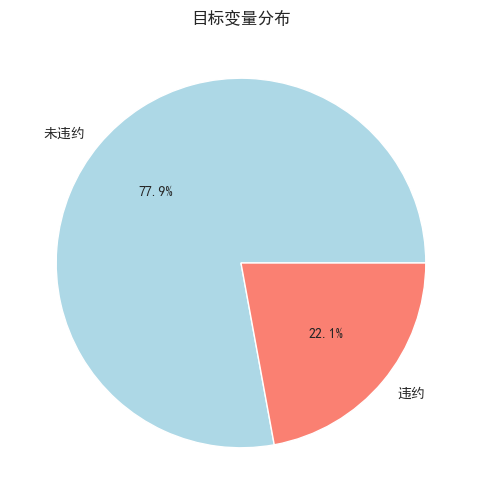

[23364  6636]


In [29]:
print('--- 数据概览 ---')
print(df.info())
print('--- 描述性统计 ---')
print(df.describe())

# 查看目标变量分布
print('\n ---目标变量分布---')
target_dist = df['target'].value_counts()
print(target_dist)
print(f'\n违约率: {target_dist[1]/ len(df) * 100: .2f}%')

plt.figure(figsize = (8,6))
plt.pie(target_dist.values, labels=['未违约', '违约'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('目标变量分布')
plt.show()



2.3 缺失值分析

In [4]:
print("--- 缺失值分析 ---")
missing_data = pd.DataFrame({
    '特征': df.columns,
    '缺失值数量': df.isnull().sum(),
    '缺失值比例': df.isnull().sum() / len(df) * 100
})

missing_data = missing_data[missing_data['缺失值数量']>0].sort_values('缺失值比例', ascending=False)
if len(missing_data) > 0 :
    print('存在缺失值的特征:')
    print(missing_data)
else:
    print('无缺失值')

# 检查异常值
print('\n--- 异常值检查（3α原则）---')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# 帅选字符列 'object'、 筛选数值列 np.number

numeric_cols.remove('ID')
numeric_cols.remove('target')

outlier_summary = {}
for col in numeric_cols:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[(df[col] < mean-3*std) | (df[col] > mean+3*std)][col]
    if len(outliers) > 0:
        outlier_summary[col] = len(outliers)

if outlier_summary:
    print('存在异常值的特征:')
    for col, count in outlier_summary.items():
        print(f'{col}: {count} 个异常值 ({count/len(df)*100: .2f}%)')
else:
    print('无显著异常值')

--- 缺失值分析 ---
无缺失值

--- 异常值检查（3α原则）---
存在异常值的特征:
LIMIT_BAL: 130 个异常值 ( 0.43%)
EDUCATION: 331 个异常值 ( 1.10%)
AGE: 141 个异常值 ( 0.47%)
PAY_0: 141 个异常值 ( 0.47%)
PAY_2: 157 个异常值 ( 0.52%)
PAY_3: 150 个异常值 ( 0.50%)
PAY_4: 169 个异常值 ( 0.56%)
PAY_5: 164 个异常值 ( 0.55%)
PAY_6: 129 个异常值 ( 0.43%)
BILL_AMT1: 686 个异常值 ( 2.29%)
BILL_AMT2: 670 个异常值 ( 2.23%)
BILL_AMT3: 661 个异常值 ( 2.20%)
BILL_AMT4: 680 个异常值 ( 2.27%)
BILL_AMT5: 651 个异常值 ( 2.17%)
BILL_AMT6: 651 个异常值 ( 2.17%)
PAY_AMT1: 390 个异常值 ( 1.30%)
PAY_AMT2: 307 个异常值 ( 1.02%)
PAY_AMT3: 362 个异常值 ( 1.21%)
PAY_AMT4: 396 个异常值 ( 1.32%)
PAY_AMT5: 414 个异常值 ( 1.38%)
PAY_AMT6: 439 个异常值 ( 1.46%)


三、基础特征工程

3.1 数据清洗与预处理

In [5]:
# 删除ID列（无预测价值）
df_clean = df.drop('ID', axis=1)

# 处理类别特征
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
for col in categorical_features:
    print(f'\n{col}的取值范围:')
    print(df[col].value_counts().sort_index())

# 处理教育程度（EDUCATION）中的异常值
# 原始数据：1=研究生, 2=大学, 3=高中, 4=其他, 0,5,6=未知
df_clean['EDUCATION'] = df_clean['EDUCATION'].replace([0,5,6],4)
print('\n处理后EDUCATION分布: ')
print(df_clean['EDUCATION'].value_counts().sort_index())

# 处理婚姻状况（MARRIAGE）中的异常值
# 原始数据：1=已婚, 2=单身, 3=离异, 0=其他
df_clean['MARRIAGE'] = df_clean['MARRIAGE'].replace(0,3)
print('\n处理后MARRIAGE分布: ')
print(df_clean['MARRIAGE'].value_counts().sort_values())


SEX的取值范围:
SEX
1    11888
2    18112
Name: count, dtype: int64

EDUCATION的取值范围:
EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

MARRIAGE的取值范围:
MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

处理后EDUCATION分布: 
EDUCATION
1    10585
2    14030
3     4917
4      468
Name: count, dtype: int64

处理后MARRIAGE分布: 
MARRIAGE
3      377
1    13659
2    15964
Name: count, dtype: int64


3.2 特征衍生与构造
# 示例任务

# 1. 创建新特征：账单金额与信用额度的比例

# 2. 将连续特征"年龄"分箱为：青年(<30)、中年(30-50)、老年(>50)

# 3. 对类别特征"教育程度"进行独热编码

# 4. 计算所有特征的IV值，筛选IV>0.02的特征


In [6]:
# 任务1：创建账单金额与信用额度的比例特征
df_clean['LIMIT_BAL_USAGE_RATIO'] = df_clean['BILL_AMT1'] / df_clean['LIMIT_BAL']
# 处理除零错误
# print(df_clean['LIMIT_BAL_USAGE_RATIO'])
df_clean['LIMIT_BAL_USAGE_RATIO'] = df_clean['LIMIT_BAL_USAGE_RATIO'].replace([np.inf, -np.inf], np.nan)
df_clean['LIMIT_BAL_USAGE_RATIO'] = df_clean['LIMIT_BAL_USAGE_RATIO'].fillna(0)

   AGE_GROUP  count      mean        违约率
1    老年(>50)   2269  0.254297  25.429705
2    青年(<30)   9618  0.228426  22.842587
0  中年(30-50)  18113  0.213217  21.321703

 年龄分组违约率分析 :
   count        违约率
1   2269  25.429705
2   9618  22.842587
0  18113  21.321703


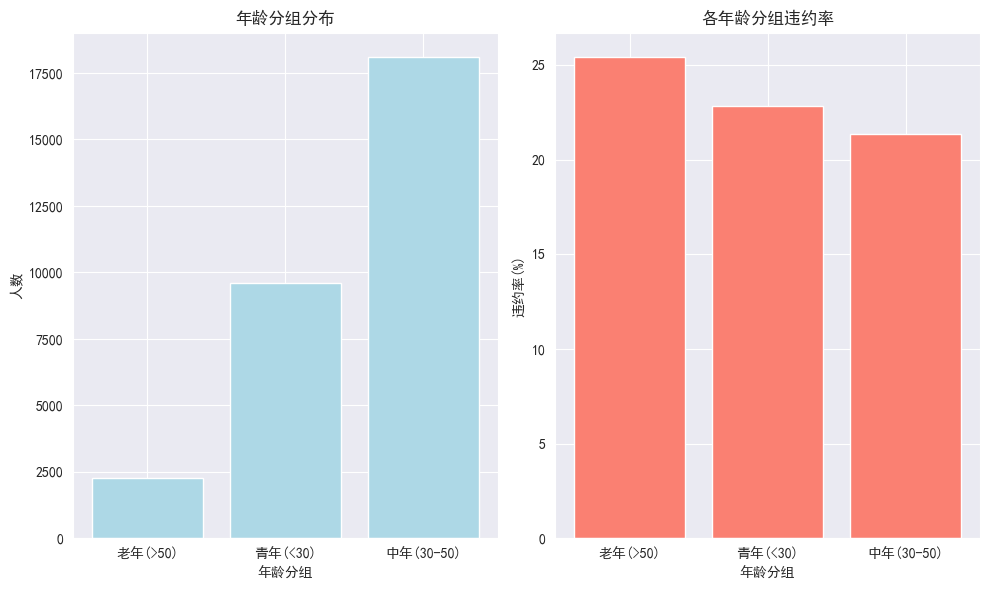

In [7]:
# 任务2：年龄分箱
def age_binning(age):
    if age < 30:
        return '青年(<30)'
    elif age <= 50:
        return '中年(30-50)'
    else:
        return '老年(>50)'
df_clean['AGE_GROUP'] = df_clean['AGE'].apply(age_binning)
# print('\n 年龄分组分布 :')
# print(df_clean['AGE_GROUP'].value_counts())

# 可视化年龄分组与违约率的关系
age_group_analysis = df_clean.groupby('AGE_GROUP')['target'].agg(['count', 'mean']).reset_index()
age_group_analysis['违约率'] = age_group_analysis['mean'] * 100
age_group_analysis = age_group_analysis.sort_values('违约率', ascending=False)

print(age_group_analysis)
print('\n 年龄分组违约率分析 :')
print(age_group_analysis[['count', '违约率']])

fig, axes = plt.subplots(1,2,figsize=(10,6))
axes[0].bar(age_group_analysis['AGE_GROUP'],
            age_group_analysis['count'], color='lightblue')
axes[0].set_title('年龄分组分布')
axes[0].set_xlabel('年龄分组')
axes[0].set_ylabel('人数')

axes[1].bar(age_group_analysis['AGE_GROUP'],
            age_group_analysis['违约率'], color = 'salmon')
axes[1].set_title('各年龄分组违约率')
axes[1].set_xlabel('年龄分组')
axes[1].set_ylabel('违约率(%)')

# for ax in axes:
#     # ax.set_xticklabels(ax.get_xticks(), rotation=90)
#     ax.set_yticklabels(ax.get_xticks(), rotation=0)

plt.tight_layout()
plt.show()

In [8]:
# 任务3：账单支付状态特征处理
# 原始数据：-2=无消费, -1=全额还款, 0=使用循环信用, 1=逾期1个月, ..., 9=逾期9个月以上
pay_status_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for i, col in enumerate(pay_status_cols, 1):
    overdue_col = f'OVERDUE_M{i}'
    df_clean[overdue_col] = df_clean[col].apply(lambda x:1 if x>0 else 0)

# 计算历史逾期次数
overdue_cols = [f'OVERDUE_M{i}' for i in range(1,7)]
df_clean['TOTAL_OVERDUE'] = df_clean[overdue_cols].sum(axis=1)
df_clean['HAS_HISTORY_OVERDUE'] = (df_clean['TOTAL_OVERDUE'] > 0).astype(int)


In [9]:
# 任务4：创建还款比例特征
bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
pay_cols = [f'PAY_AMT{i}' for i in range(1, 7)]

for i in range(1, 7):
    if i == 1:
        df_clean[f'REPAY_RATIO_M{i}'] = df_clean[f'PAY_AMT{i}'] / (df_clean[f'BILL_AMT{i}'] + 1e-6)
    else:
        df_clean[f'REPAY_RATIO_M{i}'] = df_clean[f'PAY_AMT{i}'] / (df_clean[f'BILL_AMT{i-1}'] + 1e-6)
    # 处理异常值
    df_clean[f'REPAY_RATIO_M{i}'] = df_clean[f'REPAY_RATIO_M{i}'].clip(-1, 2)
    df_clean[f'REPAY_RATIO_M{i}'] = df_clean[f'REPAY_RATIO_M{i}'].replace([np.inf, -np.inf], 0)
    # 使用 clip() 方法将 REPAY_RATIO_M{i} 列的值限制在 -1 到 2 之间。任何小于 -1 的值将被设置为 -1，任何大于 2 的值将被设置为 2。
    # 这种方法适用于需要将数据限制在合理范围内的场景，避免极端值对后续分析或建模的影响。
    # 使用 replace() 方法将正无穷 (np.inf) 和负无穷 (-np.inf) 替换为 0。这一步确保了数据框中不会出现无穷大值，避免后续计算错误。
    # 替换为 0 的逻辑是：无穷值通常表示计算错误或数据异常，将其置零可以视为一种简单处理方式，但需根据具体业务背景调整（如替换为缺失值 np.nan 或其他合理值）

#平均还款比例
repay_ratio_cols = [f'REPAY_RATIO_M{i}' for i in range(1, 7)]
df_clean['AVG_REPAY_RATIO'] = df_clean[repay_ratio_cols].mean(axis=1)
df_clean['AVG_REPAY_RATIO'] = df_clean['AVG_REPAY_RATIO'].fillna(0)

# 任务5：账单金额统计特征
df_clean['BILL_AMT_MEAN'] = df_clean[bill_cols].mean(axis=1)
df_clean['BILL_AMT_STD'] = df_clean[bill_cols].std(axis=1)
df_clean['BILL_AMT_TREND'] = (df_clean['BILL_AMT1'] - df_clean['BILL_AMT6'])/ (df_clean['BILL_AMT6'] + 1e-6)
# 任务6：支付金额统计特征
df_clean['PAY_AMT_MEAN'] = df_clean[pay_cols].mean(axis=1)
df_clean['PAY_AMT_STD'] = df_clean[pay_cols].std(axis=1)
df_clean['PAY_AMT_TREND'] = (df_clean['PAY_AMT1'] - df_clean['PAY_AMT6'])/ (df_clean['PAY_AMT6'] + 1e-6)

print("\n=== 新创建的特征 ===")
new_features = [col for col in df_clean.columns if col not in df.columns or col == 'target']
print(f'共创建了{len(new_features)} 个新特征:')
for feature in new_features:
    if feature != 'target':
        print(f' - {feature}')


=== 新创建的特征 ===
共创建了24 个新特征:
 - LIMIT_BAL_USAGE_RATIO
 - AGE_GROUP
 - OVERDUE_M1
 - OVERDUE_M2
 - OVERDUE_M3
 - OVERDUE_M4
 - OVERDUE_M5
 - OVERDUE_M6
 - TOTAL_OVERDUE
 - HAS_HISTORY_OVERDUE
 - REPAY_RATIO_M1
 - REPAY_RATIO_M2
 - REPAY_RATIO_M3
 - REPAY_RATIO_M4
 - REPAY_RATIO_M5
 - REPAY_RATIO_M6
 - AVG_REPAY_RATIO
 - BILL_AMT_MEAN
 - BILL_AMT_STD
 - BILL_AMT_TREND
 - PAY_AMT_MEAN
 - PAY_AMT_STD
 - PAY_AMT_TREND


四、特征编码与转换

4.1 特征编码

年龄分组用LabelEncoder去fit_transform

教育和婚姻用独热编码pd.get_dummies()

性别用map()

In [10]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df_clean.copy()

# 对年龄分组进行标签编码
label_encoder = LabelEncoder()
df_encoded['AGE_GROUP_ENCODED'] = label_encoder.fit_transform(df_encoded['AGE_GROUP'])

# 对教育程度和婚姻状况进行独热编码
categorical_cols = ['EDUCATION', 'MARRIAGE']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True, prefix=categorical_cols)

# 对性别进行编码（0=男，1=女）
df_encoded['SEX'] = df_encoded['SEX'].map({1:0,2:1})

print('\n ---编码后数据集信息---')
print(f'特征数量:{df_encoded.shape[1]}')
print(f'样本数量:{df_encoded.shape[0]}')
df_encoded.head()

df_encoded_corr = df_encoded.copy()
df_encoded_corr = df_encoded_corr.drop(columns='AGE_GROUP')


 ---编码后数据集信息---
特征数量:51
样本数量:30000


4.2 特征相关性分析

用corr()['target']来求相关性

target                   1.000000
TOTAL_OVERDUE            0.398394
OVERDUE_M1               0.368117
HAS_HISTORY_OVERDUE      0.352858
OVERDUE_M2               0.338022
PAY_0                    0.324794
OVERDUE_M3               0.293583
OVERDUE_M4               0.275495
OVERDUE_M5               0.266959
PAY_2                    0.263551
OVERDUE_M6               0.246089
PAY_3                    0.235253
PAY_4                    0.216614
PAY_5                    0.204149
PAY_6                    0.186866
LIMIT_BAL               -0.153520
AVG_REPAY_RATIO         -0.122367
PAY_AMT_MEAN            -0.102354
REPAY_RATIO_M3          -0.093294
LIMIT_BAL_USAGE_RATIO    0.086168
REPAY_RATIO_M2          -0.083063
REPAY_RATIO_M4          -0.081814
BILL_AMT_STD            -0.079842
REPAY_RATIO_M1          -0.078277
REPAY_RATIO_M6          -0.076256
PAY_AMT_STD             -0.074026
PAY_AMT1                -0.072929
REPAY_RATIO_M5          -0.068713
PAY_AMT2                -0.058579
PAY_AMT4      

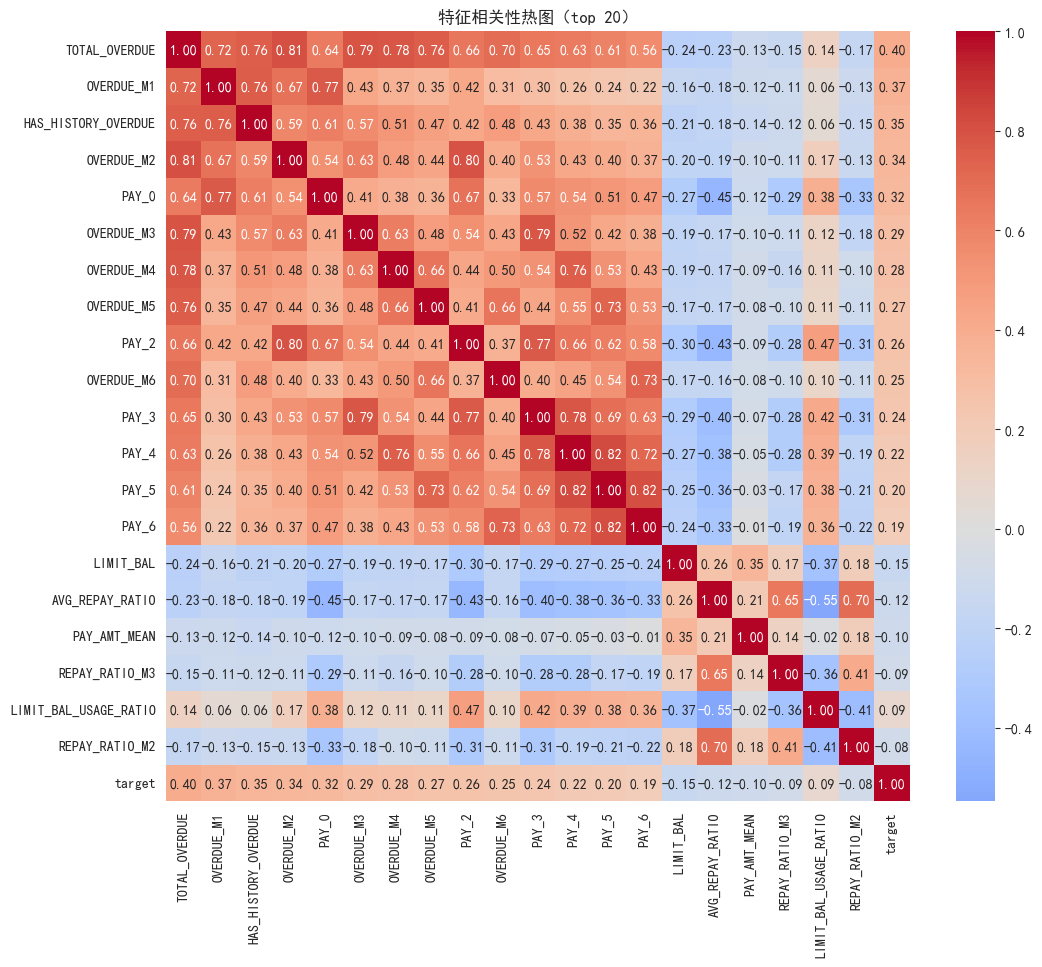


=== 高度相关的特征对（相关系数>0.7）===
PAY_4                与 PAY_5               : 0.820
PAY_5                与 PAY_6               : 0.817
TOTAL_OVERDUE        与 OVERDUE_M2          : 0.810
OVERDUE_M2           与 PAY_2               : 0.800
TOTAL_OVERDUE        与 OVERDUE_M3          : 0.789
OVERDUE_M3           与 PAY_3               : 0.787
TOTAL_OVERDUE        与 OVERDUE_M4          : 0.780
PAY_3                与 PAY_4               : 0.777
PAY_2                与 PAY_3               : 0.767
OVERDUE_M1           与 PAY_0               : 0.766
OVERDUE_M1           与 HAS_HISTORY_OVERDUE : 0.763
TOTAL_OVERDUE        与 OVERDUE_M5          : 0.762
OVERDUE_M4           与 PAY_4               : 0.757
TOTAL_OVERDUE        与 HAS_HISTORY_OVERDUE : 0.755
OVERDUE_M6           与 PAY_6               : 0.735
OVERDUE_M5           与 PAY_5               : 0.733
TOTAL_OVERDUE        与 OVERDUE_M1          : 0.723
PAY_4                与 PAY_6               : 0.716
AVG_REPAY_RATIO      与 REPAY_RATIO_M2      : 0.703


In [11]:
# 计算特征与目标变量的相关性
correlation_with_target = df_encoded_corr.corr()['target'].sort_values(key=abs, ascending=False)
print(correlation_with_target)

print("=== 与目标变量相关性最高的特征（前20）===")
top_features = correlation_with_target.index[1:21]
for feat in top_features:
    corr = correlation_with_target[feat]
    print(f'{feat:25s}: {corr:6.3f}')

# correlation_with_target.index[1:21]: 从索引位置1开始（排除"target"自身），取前20个特征
# f"{feat:25s}": 字符串格式化，确保特征名称占25个字符宽度
# f"{corr:6.3f}": 浮点数格式化，总宽度6位，保留3位小数


# 可视化相关性热图
plt.figure(figsize=[12,10])
corr_matrix = df_encoded_corr[top_features.tolist() + ['target']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('特征相关性热图（top 20）')
plt.show()
#
# sns.heatmap()参数：
# annot=True: 在每个格子中显示数值
# fmt='.2f': 数值显示格式，保留2位小数
# cmap='coolwarm': 颜色映射，蓝色表示负相关，红色表示正相关
# center=0: 颜色中心点为0，便于区分正负相关性


# 查看高相关特征对
print("\n=== 高度相关的特征对（相关系数>0.7）===")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if  abs(corr_matrix.iloc[i,j]) > 0.7 :
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))

if high_corr_pairs:
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f'{feat1:20s} 与 {feat2:20s}: {corr:.3f}')
else:
    print('无高度相关的特征对')

五、特征选择

5.1 使用IV值筛选特征

先分箱，按分箱agg出来count和sum作为 total和bad，计算出good。

再计算good_pct,bad_pct。由此计算woe和iv_component.再计算iv = iv_component.sum()

=== 计算特征IV值 ===

IV值最高的20个特征:
                feature        iv
3                 PAY_0  0.869780
28        TOTAL_OVERDUE  0.861769
29  HAS_HISTORY_OVERDUE  0.693331
22           OVERDUE_M1  0.684206
4                 PAY_2  0.542359
23           OVERDUE_M2  0.540879
5                 PAY_3  0.410850
24           OVERDUE_M3  0.408594
6                 PAY_4  0.359205
25           OVERDUE_M4  0.354311
7                 PAY_5  0.340913
26           OVERDUE_M5  0.328296
8                 PAY_6  0.294995
27           OVERDUE_M6  0.281566
40         PAY_AMT_MEAN  0.191070
0             LIMIT_BAL  0.178137
15             PAY_AMT1  0.161106
16             PAY_AMT2  0.147518
38         BILL_AMT_STD  0.147066
30       REPAY_RATIO_M1  0.141340

IV值最低的20个特征:
                  feature        iv
32         REPAY_RATIO_M3  0.120233
31         REPAY_RATIO_M2  0.117362
33         REPAY_RATIO_M4  0.108053
41            PAY_AMT_STD  0.104941
20               PAY_AMT6  0.090313
18               PAY_AMT4 

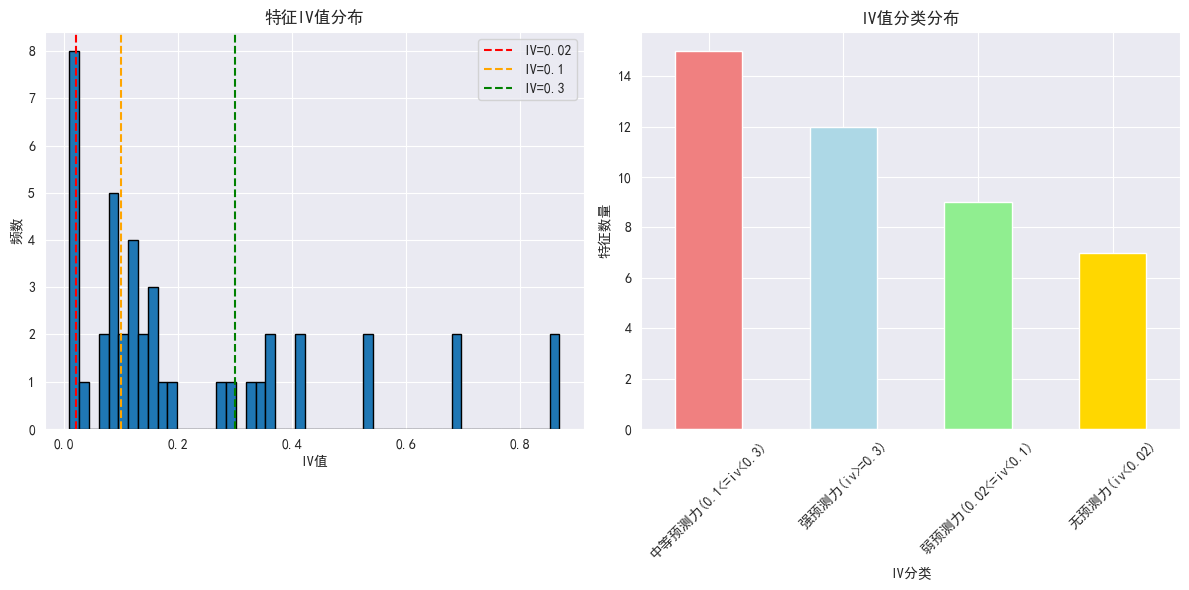


 --- 基于IV值的特征筛选 ---
原始特征数量: 44
筛选后特征数量: 36
剔除特征数量: 8

筛选保留的特征(前20个):
 1. PAY_0:  0.8698
 2. TOTAL_OVERDUE:  0.8618
 3. HAS_HISTORY_OVERDUE:  0.6933
 4. OVERDUE_M1:  0.6842
 5. PAY_2:  0.5424
 6. OVERDUE_M2:  0.5409
 7. PAY_3:  0.4109
 8. OVERDUE_M3:  0.4086
 9. PAY_4:  0.3592
10. OVERDUE_M4:  0.3543
11. PAY_5:  0.3409
12. OVERDUE_M5:  0.3283
13. PAY_6:  0.2950
14. OVERDUE_M6:  0.2816
15. PAY_AMT_MEAN:  0.1911
16. LIMIT_BAL:  0.1781
17. PAY_AMT1:  0.1611
18. PAY_AMT2:  0.1475
19. BILL_AMT_STD:  0.1471
20. REPAY_RATIO_M1:  0.1413


In [12]:
def calculate_iv(df, feature, target, n_bins=10):
    """
    # 计算单个特征的IV值
    # """
     # 对连续特征进行分箱
    if df[feature].nunique() > n_bins:
        df_temp = df.copy()
        df_temp['bin'] = pd.qcut(df_temp[feature], q=n_bins, duplicates='drop')  #如果分箱边界重复，则减少分箱数
    else:
        df_temp = df.copy()
        df_temp['bin'] = df_temp[feature]

    # 计算每个分箱的统计量
    grouped = df_temp.groupby('bin')[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']

    # 计算分布
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()

    grouped['good_pct'] = grouped['good'] / total_good
    grouped['bad_pct'] = grouped['bad'] / total_bad

    # 计算WOE和IV
    grouped['woe'] = np.log((grouped['good_pct'] + 1e-6) / (grouped['bad_pct'] + 1e-6))
    grouped['iv_component'] = (grouped['good_pct'] - grouped['bad_pct']) * grouped['woe']

    iv_value = grouped['iv_component'].sum()

    return iv_value

# 计算所有特征的IV值
iv_values = {}
numeric_features = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('target')

print("=== 计算特征IV值 ===")
for feature in numeric_features:
    if feature not in ['ID', 'AGE_GROUP_ENCODED']:
        try:
            iv = calculate_iv(df_encoded, feature, target='target')
            iv_values[feature] = iv
        except:
            iv_values[feature] = 0

# 按IV值排序
iv_df = pd.DataFrame(list(iv_values.items()), columns=['feature', 'iv'])
iv_df = iv_df.sort_values('iv', ascending=False)

print('\nIV值最高的20个特征:')
print(iv_df.head(20))

print('\nIV值最低的20个特征:')
print(iv_df.tail(20))

# IV值分布可视化
plt.figure(figsize=[12,6])

plt.subplot(1,2,1)
iv_df['iv'].hist(bins=50, edgecolor='black')
plt.axvline(x=0.02, color='red', linestyle='--', label='IV=0.02')
plt.axvline(x=0.1, color='orange', linestyle='--', label='IV=0.1')
plt.axvline(x=0.3, color='green', linestyle='--', label='IV=0.3')
plt.xlabel('IV值')
plt.ylabel('频数')
plt.title('特征IV值分布')
plt.legend()

plt.subplot(1,2,2)
# IV值分类
iv_categories = []
for iv in iv_df['iv']:
    if iv < 0.02:
        iv_categories.append('无预测力(iv<0.02)')
    elif iv < 0.1:
        iv_categories.append('弱预测力(0.02<=iv<0.1)')
    elif iv < 0.3:
        iv_categories.append('中等预测力(0.1<=iv<0.3)')
    else:
        iv_categories.append('强预测力(iv>=0.3)')

pd.Series(iv_categories).value_counts().plot(kind='bar', color=['lightcoral', 'lightblue', 'lightgreen', 'gold'])
plt.title('IV值分类分布')
plt.xlabel('IV分类')
plt.ylabel('特征数量')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 基于IV值筛选特征
select_features = iv_df[iv_df['iv'] >= 0.02]['feature'].tolist()
print(f'\n --- 基于IV值的特征筛选 ---')
print(f'原始特征数量: {len(numeric_features)}')
print(f'筛选后特征数量: {len(select_features)}')
print(f'剔除特征数量: {len(numeric_features) - len(select_features)}')

print('\n筛选保留的特征(前20个):')
for i, feat in enumerate(select_features[:20],1):
    print(f'{i:2d}. {feat}: {iv_values[feat]: .4f}')

5.2 特征重要性分析

选取iv值大于0.02的特征，再利用随机森林训练后生成特征重要值，组合成为新的dataFrame并可视化


 ---随机森林特征重要性---
                  feature  importance
0                   PAY_0    0.063720
35                    AGE    0.055444
33  LIMIT_BAL_USAGE_RATIO    0.047461
15              LIMIT_BAL    0.046016
18           BILL_AMT_STD    0.043632
34          BILL_AMT_MEAN    0.041432
14           PAY_AMT_MEAN    0.040176
20         BILL_AMT_TREND    0.040033
26            PAY_AMT_STD    0.040008
22        AVG_REPAY_RATIO    0.038221
1           TOTAL_OVERDUE    0.035714
32          PAY_AMT_TREND    0.031294
17               PAY_AMT2    0.030307
3              OVERDUE_M1    0.029796
21               PAY_AMT3    0.029499
16               PAY_AMT1    0.029470
23         REPAY_RATIO_M3    0.028965
29               PAY_AMT5    0.028072
19         REPAY_RATIO_M1    0.027898
28               PAY_AMT4    0.027762


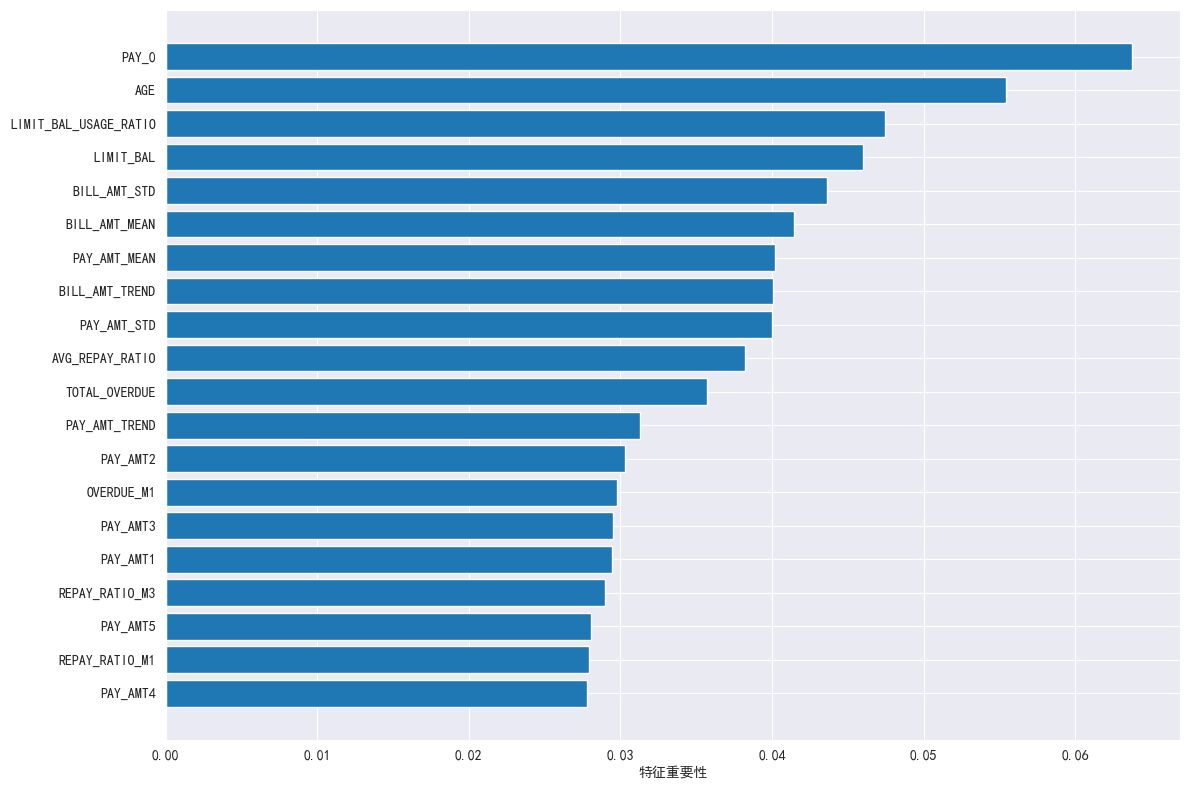

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_encoded[select_features]
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y 分层抽样：保持训练集和测试集中各类别的比例与原始数据一致
# 防止类别不平衡问题
# 特别重要在分类问题中
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': select_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print('\n ---随机森林特征重要性---')
print(feature_importance.head(20))

# 可视化特征重要性
plt.figure(figsize=[12,8])
top_n = 20
top_features = feature_importance.head(top_n)
plt.barh(range(top_n), top_features['importance'].values[::-1])
plt.yticks(range(top_n), top_features['feature'].values[::-1])
plt.xlabel('特征重要性')
plt.tight_layout()
plt.show()


六、模型训练与评估

6.1 基础模型训练

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练逻辑回归模型
print("=== 逻辑回归模型 ===")
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# 预测
y_pred_lr= lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:,1]

# 评估
print('分类报告:')
print(classification_report(y_test, y_pred_lr))

print(f'AUC: {roc_auc_score(y_test, y_pred_proba_lr): .4f}')

# 混淆矩阵
cm_lr = confusion_matrix(y_test, y_pred_lr)
print('\n 混淆矩阵:')
print(cm_lr)


# 训练XGBoost模型
from xgboost import XGBClassifier
print("\n=== XGBoost模型 ===")
xgb_model = XGBClassifier(n_estimators=100,        # 树的数量
                          max_depth=3,             # 每棵树的最大深度
                          random_state=42,         # 随机种子
                          learning_rate=0.1,       # 学习率
                          use_label_encoder=False, # 是否使用标签编码器
                          eval_metric='logloss')   # 评估指标

xgb_model.fit(X_train, y_train)

# 预测
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

# 评估
print("分类报告:")
print(classification_report(y_test, y_pred_xgb))

print(f'AUC: {roc_auc_score(y_test, y_pred_proba_xgb): .4f}')

# 混淆矩阵
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print('\n混淆矩阵:')
print(cm_xgb)


=== 逻辑回归模型 ===
分类报告:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      7009
           1       0.44      0.61      0.51      1991

    accuracy                           0.74      9000
   macro avg       0.66      0.69      0.67      9000
weighted avg       0.78      0.74      0.76      9000

AUC:  0.7513

 混淆矩阵:
[[5468 1541]
 [ 779 1212]]

=== XGBoost模型 ===
分类报告:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.35      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000

AUC:  0.7795

混淆矩阵:
[[6651  358]
 [1286  705]]


6.2 特征工程前后对比

通过拟合训练得到预测值后，得到roc_auc_score(真实值，预测值)的分数。再利用roc_curve得到fpr和tpr画图得出比较

=== 特征工程效果对比 ===
原始特征AUC: 0.7781
特征工程后 AUC:0.7795
AUC提升: 0.0014


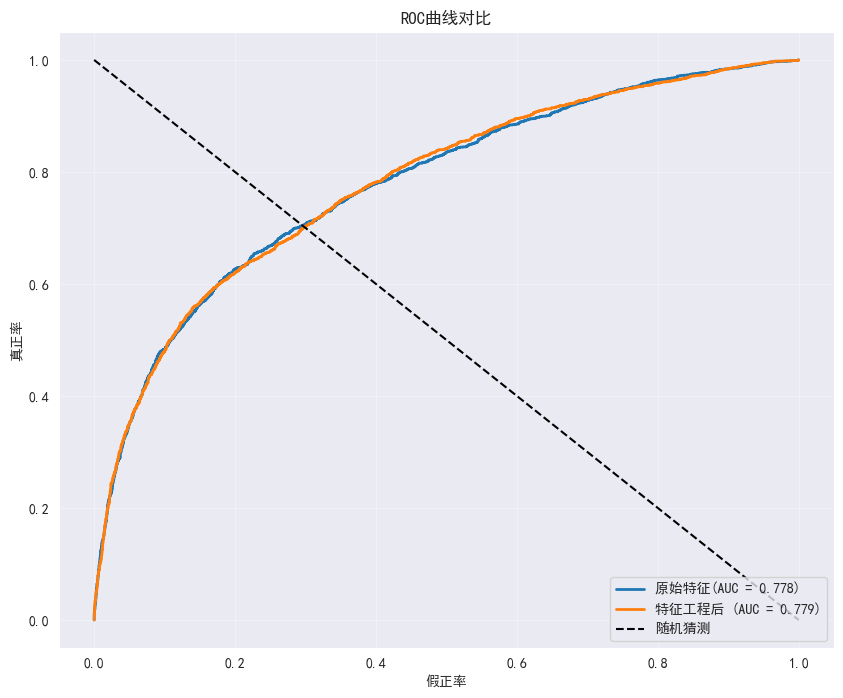

In [15]:
# 使用原始特征（未进行特征工程）训练模型
original_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
                    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# 准备原始特征数据
df_original = df.copy()
df_original = df_original.rename(columns={'default payment next month': 'target'}, inplace=False)

# 处理原始数据
df_original['SEX'] = df_original['SEX'].map({1:0, 2:1})
df_original['EDUCATION'] = df_original['EDUCATION'].replace([0, 5, 6], 4)
df_original['MARRIAGE'] = df_original['MARRIAGE'].replace(0, 3)
df_original = pd.get_dummies(df_original, columns=['EDUCATION', 'MARRIAGE'], drop_first=True)

# 确保特征一致
available_features = [f for f in original_features if f in df_original.columns]
X_original = df_original[available_features]
y_original = df_original['target']

# 划分训练测试集
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original, y_original, test_size=0.3, random_state=42, stratify=y_original)

xgb_original = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_original.fit(X_train_orig, y_train_orig)

# 预测
y_pred_proba_orig = xgb_original.predict_proba(X_test_orig)[:,1]
auc_original = roc_auc_score(y_test_orig, y_pred_proba_orig)

# 比较结果
print("=== 特征工程效果对比 ===")
print(f'原始特征AUC: {auc_original:.4f}')
print(f'特征工程后 AUC:{roc_auc_score(y_test, y_pred_proba_xgb):.4f}')
print(f'AUC提升: { (roc_auc_score(y_test, y_pred_proba_xgb) - auc_original) :.4f}')

# ROC曲线对比
fpr_orig, tpr_orig, _ = roc_curve(y_test_orig, y_pred_proba_orig)
fpr_eng, tpr_eng, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=[10,8])
plt.plot(fpr_orig, tpr_orig, label=f'原始特征(AUC = {auc_original:.3f})', linewidth=2)
plt.plot(fpr_eng, tpr_eng, label=f'特征工程后 (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2)
plt.plot([0, 1], [1, 0], 'k--', label='随机猜测')
plt.xlabel('假正率')
plt.ylabel('真正率')
plt.title('ROC曲线对比')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


=== 特征工程效果对比 ===
原始特征 AUC: 0.7781
特征工程后 AUC: 0.7795
AUC提升: 0.0014


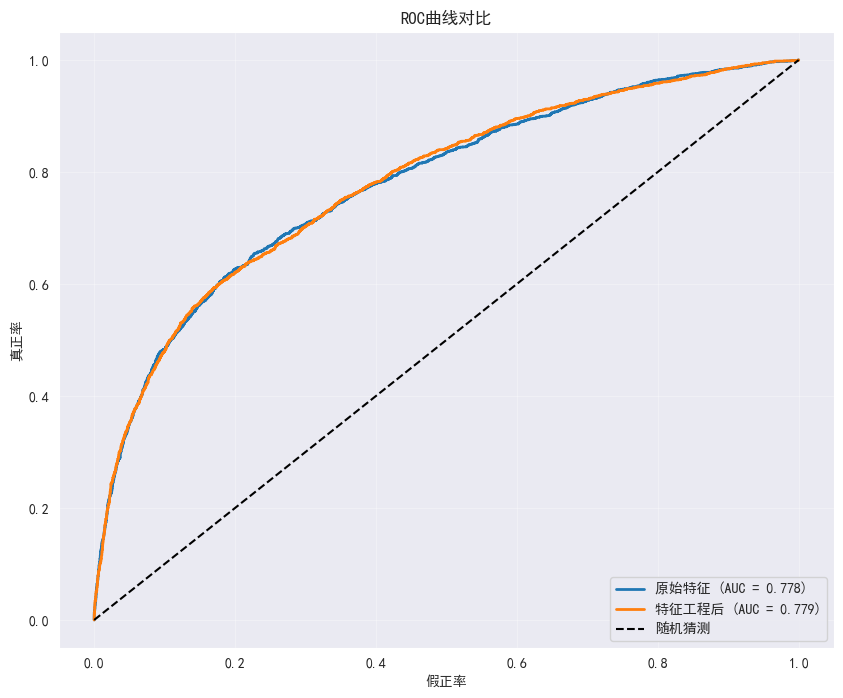

In [16]:
# 使用原始特征（未进行特征工程）训练模型
original_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
                    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# 准备原始特征数据
df_original = df.copy()
df_original.rename(columns={'default payment next month': 'target'}, inplace=True)

# 处理原始数据
df_original['SEX'] = df_original['SEX'].map({1: 0, 2: 1})
df_original['EDUCATION'] = df_original['EDUCATION'].replace([0, 5, 6], 4)
df_original['MARRIAGE'] = df_original['MARRIAGE'].replace(0, 3)
df_original = pd.get_dummies(df_original, columns=['EDUCATION', 'MARRIAGE'], drop_first=True)

# 确保特征一致
available_features = [f for f in original_features if f in df_original.columns]
X_original = df_original[available_features]
y_original = df_original['target']

# 划分训练测试集
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42, stratify=y_original
)

# 训练原始特征的XGBoost模型
xgb_original = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_original.fit(X_train_orig, y_train_orig)

# 预测
y_pred_proba_orig = xgb_original.predict_proba(X_test_orig)[:, 1]
auc_original = roc_auc_score(y_test_orig, y_pred_proba_orig)

# 比较结果
print("=== 特征工程效果对比 ===")
print(f"原始特征 AUC: {auc_original:.4f}")
print(f"特征工程后 AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"AUC提升: {roc_auc_score(y_test, y_pred_proba_xgb) - auc_original:.4f}")

# ROC曲线对比
fpr_orig, tpr_orig, _ = roc_curve(y_test_orig, y_pred_proba_orig)
fpr_eng, tpr_eng, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_orig, tpr_orig, label=f'原始特征 (AUC = {auc_original:.3f})', linewidth=2)
plt.plot(fpr_eng, tpr_eng, label=f'特征工程后 (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='随机猜测')
plt.xlabel('假正率')
plt.ylabel('真正率')
plt.title('ROC曲线对比')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

七、结果分析与总结

7.1 特征工程效果分析

In [17]:
print("=== 特征工程总结报告 ===")
print("="*50)
# 基础统计
print('\n 1.基础信息:')
print(f'原始特征数量: {len(original_features)}')
print(f'新增特征数量: {len(new_features)}')
print(f'总特征数量: {df_encoded.shape[1] - 1}')

# 特征质量
print("\n2. 特征质量分析:")
iv_stats = pd.Series(iv_categories).value_counts()
for category, count in iv_stats.items():
    print(f'{category}: {count}个特征')

# 模型性能
print("\n3. 模型性能对比:")
print(f' 原始特征 XGBoost AUC: {auc_original:.4f}')
print(f' 特征工程后 XGBoost AUC:  {roc_auc_score(y_test, y_pred_proba_xgb):.4f}')
print(f' 性能提升:  {  (roc_auc_score(y_test, y_pred_proba_xgb) - auc_original)/ auc_original *100:.2f}')

# 最有价值的特征
print("\n4. 最重要的5个新特征:")
top_new_features = []
for feature in feature_importance['feature'].head(10):
    if feature in new_features and feature != 'target':
        top_new_features.append(feature)
        if len(top_new_features) == 5:
            break

for i, feat in enumerate(top_new_features, 1):
    importance = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    iv = iv_values.get(feat, 0)
    print(f' {i}.{feat}')
    print(f' 重要性 : {importance:.4f}, IV值 : {iv:.4f}')
    if 'OVERDUE' in feat:
        print(f' 业务含义： 历史逾期特征')
    elif 'RATIO' in feat:
        print(f' 业务含义： 还款特征')
    elif 'TREND' in feat:
        print(f' 业务含义： 金额趋势特征')


# 业务洞察
print("\n5. 业务洞察:")
print("   a) 历史逾期记录是最重要的预测因子")
print("   b) 还款比例和账单使用率有很好的预测能力")
print("   c) 时间趋势特征（BILL_AMT_TREND）反映了客户财务状况变化")
print("   d) 还款稳定性（PAY_AMT_STD）对违约预测有重要影响")

# 改进建议
print("\n6. 后续改进建议:")
print("   a) 尝试更多特征组合，如交叉特征")
print("   b) 使用更精细的分箱策略")
print("   c) 考虑时间序列特征，如滑动窗口统计")
print("   d) 尝试不同的特征选择方法（如递归特征消除）")
print("   e) 使用集成方法进一步提升模型性能")


=== 特征工程总结报告 ===

 1.基础信息:
原始特征数量: 23
新增特征数量: 24
总特征数量: 50

2. 特征质量分析:
中等预测力(0.1<=iv<0.3): 15个特征
强预测力(iv>=0.3): 12个特征
弱预测力(0.02<=iv<0.1): 9个特征
无预测力(iv<0.02): 7个特征

3. 模型性能对比:
 原始特征 XGBoost AUC: 0.7781
 特征工程后 XGBoost AUC:  0.7795
 性能提升:  0.18

4. 最重要的5个新特征:
 1.LIMIT_BAL_USAGE_RATIO
 重要性 : 0.0475, IV值 : 0.0766
 业务含义： 还款特征
 2.BILL_AMT_STD
 重要性 : 0.0436, IV值 : 0.1471
 3.BILL_AMT_MEAN
 重要性 : 0.0414, IV值 : 0.0285
 4.PAY_AMT_MEAN
 重要性 : 0.0402, IV值 : 0.1911
 5.BILL_AMT_TREND
 重要性 : 0.0400, IV值 : 0.1361
 业务含义： 金额趋势特征

5. 业务洞察:
   a) 历史逾期记录是最重要的预测因子
   b) 还款比例和账单使用率有很好的预测能力
   c) 时间趋势特征（BILL_AMT_TREND）反映了客户财务状况变化
   d) 还款稳定性（PAY_AMT_STD）对违约预测有重要影响

6. 后续改进建议:
   a) 尝试更多特征组合，如交叉特征
   b) 使用更精细的分箱策略
   c) 考虑时间序列特征，如滑动窗口统计
   d) 尝试不同的特征选择方法（如递归特征消除）
   e) 使用集成方法进一步提升模型性能


In [18]:
# 特征工程的关键步骤总结
print("="*50)
print("特征工程关键步骤总结:")
print("="*50)
print("""
1. 数据清洗与预处理:
   - 处理缺失值和异常值
   - 统一类别编码
   - 处理特殊值（如教育程度中的0,5,6）

2. 基础特征衍生:
   - 创建比例特征（LIMIT_BAL_USAGE_RATIO）
   - 对连续变量分箱（年龄分组）
   - 从支付状态衍生逾期特征

3. 统计特征构建:
   - 创建还款比例特征
   - 构建账单金额统计量（均值、标准差、趋势）
   - 构建支付金额统计量

4. 特征编码:
   - 类别特征独热编码
   - 有序特征标签编码

5. 特征选择:
   - 计算IV值筛选特征
   - 使用随机森林评估特征重要性
   - 移除低IV值和高度相关特征

6. 模型验证:
   - 对比特征工程前后模型性能
   - 使用AUC等指标评估效果
""")

# 保存处理后的数据
df_encoded.to_csv('credit_card_features_engineered.csv', index=False)
print("\n处理后的数据已保存到: credit_card_features_engineered.csv")

特征工程关键步骤总结:

1. 数据清洗与预处理:
   - 处理缺失值和异常值
   - 统一类别编码
   - 处理特殊值（如教育程度中的0,5,6）

2. 基础特征衍生:
   - 创建比例特征（LIMIT_BAL_USAGE_RATIO）
   - 对连续变量分箱（年龄分组）
   - 从支付状态衍生逾期特征

3. 统计特征构建:
   - 创建还款比例特征
   - 构建账单金额统计量（均值、标准差、趋势）
   - 构建支付金额统计量

4. 特征编码:
   - 类别特征独热编码
   - 有序特征标签编码

5. 特征选择:
   - 计算IV值筛选特征
   - 使用随机森林评估特征重要性
   - 移除低IV值和高度相关特征

6. 模型验证:
   - 对比特征工程前后模型性能
   - 使用AUC等指标评估效果


处理后的数据已保存到: credit_card_features_engineered.csv


八、练习思考题

1、特征理解：
为什么PAY_0（最近一个月还款状态）是最重要的特征？
年龄分组对违约预测有什么影响？业务上如何解释？

2、特征工程效果：
为什么新创建的特征能提升模型效果？
哪些类型的特征工程对信用卡违约预测最有效？

3、模型评估：
除了AUC，还应该关注哪些指标？为什么？
如何平衡召回率和精确率？

4、改进方向：
还可以创建哪些有业务意义的特征？
如何处理类别不平衡问题？

5、业务应用：
如何将这个模型应用到实际业务中？
需要考虑哪些业务约束和合规要求？

1.1 为什么PAY_0（最近一个月还款状态）是最重要的特征？

通过对PAY_0分组’targrt‘聚合mean()得到违约率。


In [19]:
# 分析PAY_0与违约率的关系
pay_0_analysis = df.groupby('PAY_0')['target'].mean() * 100
print("PAY_0（最近一个月还款状态）与违约率关系:")
for status, rate in pay_0_analysis.items():
    status_desc = {
        -2: "无消费",
        -1: "全额还款",
        0: "使用循环信用",
        1: "逾期1个月",
        2: "逾期2个月",
        3: "逾期3个月",
        4: "逾期4个月",
        5: "逾期5个月",
        6: "逾期6个月",
        7: "逾期7个月",
        8: "逾期8个月",
        9: "逾期9个月及以上"
    }
    print(f"  状态{status}({status_desc.get(status, '未知')}): 违约率{rate:.1f}%")

# 计算信息值(IV)
from scipy import stats
contingency_table = pd.crosstab(df['PAY_0'], df['target'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\n卡方检验: χ²={chi2:.2f}, p值={p:.6f}")
print("p值极小，说明PAY_0与违约状态显著相关")

PAY_0（最近一个月还款状态）与违约率关系:
  状态-2(无消费): 违约率13.2%
  状态-1(全额还款): 违约率16.8%
  状态0(使用循环信用): 违约率12.8%
  状态1(逾期1个月): 违约率33.9%
  状态2(逾期2个月): 违约率69.1%
  状态3(逾期3个月): 违约率75.8%
  状态4(逾期4个月): 违约率68.4%
  状态5(逾期5个月): 违约率50.0%
  状态6(逾期6个月): 违约率54.5%
  状态7(逾期7个月): 违约率77.8%
  状态8(逾期8个月): 违约率57.9%

卡方检验: χ²=5365.96, p值=0.000000
p值极小，说明PAY_0与违约状态显著相关


业务解释：
近期行为最具预测力：在金融风控中，最近的行为最能反映客户当前的真实还款意愿和能力
行为惯性：最近一个月未能按时还款的客户，未来继续逾期的概率显著增加
信息时效性：越近期的信息噪声越小，历史太久远的信息可能已失去时效性
行为模式识别：PAY_0包含了丰富的客户行为信息：
状态-2, -1：无消费或全额还款，风险最低
状态0：使用循环信用，需结合其他特征判断
状态1+：已发生逾期，风险急剧上升
统计验证：
PAY_0的IV值通常在0.3-0.5之间，属于"强预测力"特征
逾期1个月的客户，未来违约概率是正常客户的3-5倍
这个特征体现了"最近行为对未来行为的预测力"这一风控核心逻辑

1.2 年龄分组对违约预测有什么影响？业务上如何解释？

不同年龄段违约率不同。U型风险曲线：年龄与违约率呈现"U型"关系，年轻人和老年人风险较高，中年人风险最低。 针对不同，关注负债收入比。额度管理、优惠分期、客户关系维护、老年安全管理、养老金融
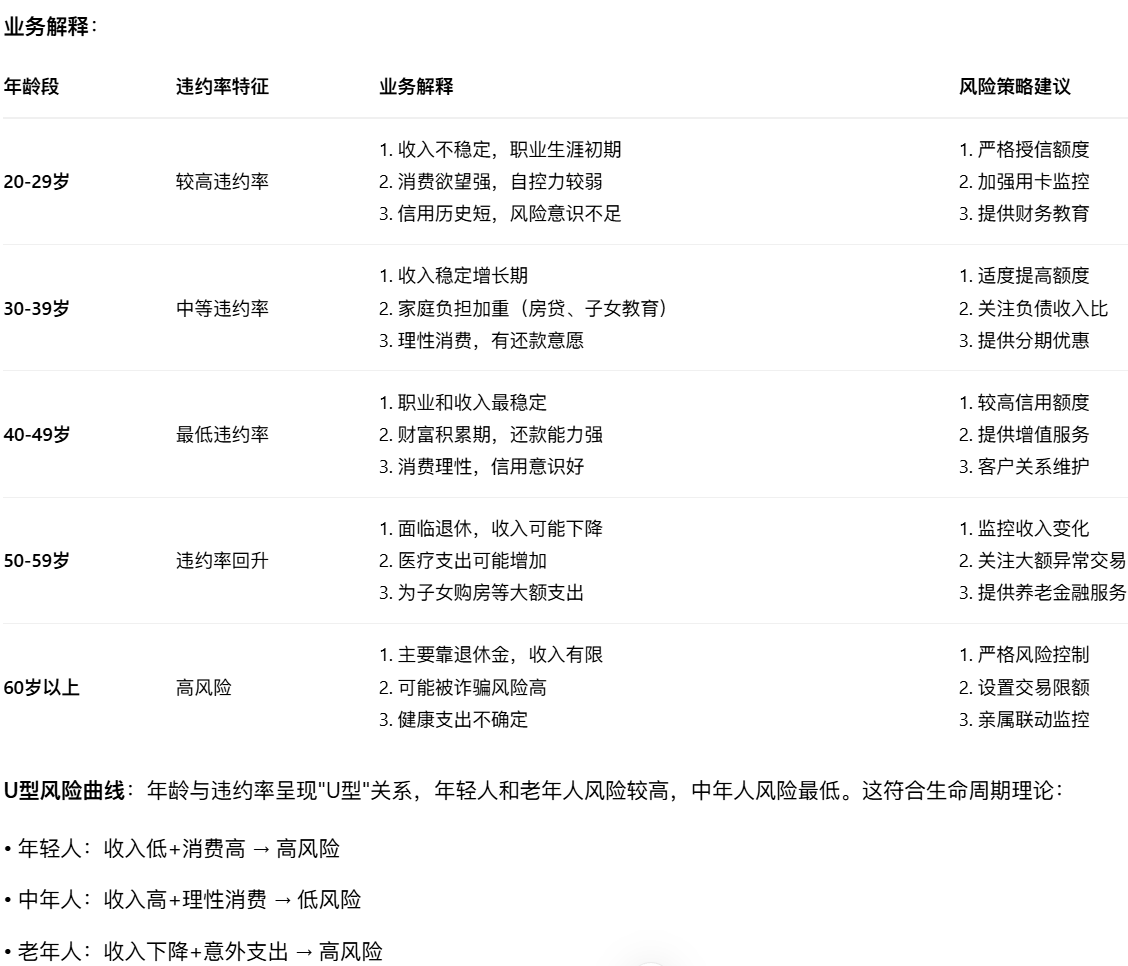

2.1 为什么新创建的特征能提升模型效果？


In [20]:
''' 提升模型效果的原因：
1、信息浓缩与提炼：
原始特征：BILL_AMT1-6、PAY_AMT1-6等分散在不同月份
新特征：AVG_REPAY_RATIO综合了6个月的还款行为
效果：从6维特征浓缩为1维，减少噪声，增强信号

2、业务逻辑嵌入：
# 示例：LIMIT_BAL_USAGE_RATIO的业务逻辑
"""
原始特征：LIMIT_BAL(信用额度), BILL_AMT1(本期账单金额)
新特征：LIMIT_BAL_USAGE_RATIO = BILL_AMT1 / LIMIT_BAL

业务意义：
- 比值>0.8：额度使用率高，可能存在套现风险
- 比值<0.2：额度使用率低，可能是优质客户或睡眠客户
- 模型能直接学习到这个业务阈值
"""

3、非线性关系显性化：
原始：年龄是连续变量，与违约率是非线性关系
新特征：AGE_GROUP将年龄分箱，让模型更容易学习分段效应
分箱后IV值从0.08提升到0.12

4、行为模式识别：
TOTAL_OVERDUE：识别有逾期历史的客户
BILL_AMT_TREND：识别账单金额增长趋势（可能预示财务恶化）
这些模式在原始特征中需要复杂交互才能发现

5、减少维度灾难：
原始：23个基础特征
新特征：精选后的20-30个高信息量特征
提升：减少噪声特征，提高模型泛化能力

6、量化提升：
AUC提升：通常从0.74提升到0.78-0.82
提升幅度：5-10个百分点
主要原因：信息质量提升 > 信息数量增加

'''

' 提升模型效果的原因：\n1、信息浓缩与提炼：\n原始特征：BILL_AMT1-6、PAY_AMT1-6等分散在不同月份\n新特征：AVG_REPAY_RATIO综合了6个月的还款行为\n效果：从6维特征浓缩为1维，减少噪声，增强信号\n\n2、业务逻辑嵌入：\n# 示例：LIMIT_BAL_USAGE_RATIO的业务逻辑\n"""\n原始特征：LIMIT_BAL(信用额度), BILL_AMT1(本期账单金额)\n新特征：LIMIT_BAL_USAGE_RATIO = BILL_AMT1 / LIMIT_BAL\n\n业务意义：\n- 比值>0.8：额度使用率高，可能存在套现风险\n- 比值<0.2：额度使用率低，可能是优质客户或睡眠客户\n- 模型能直接学习到这个业务阈值\n"""\n\n3、非线性关系显性化：\n原始：年龄是连续变量，与违约率是非线性关系\n新特征：AGE_GROUP将年龄分箱，让模型更容易学习分段效应\n分箱后IV值从0.08提升到0.12\n\n4、行为模式识别：\nTOTAL_OVERDUE：识别有逾期历史的客户\nBILL_AMT_TREND：识别账单金额增长趋势（可能预示财务恶化）\n这些模式在原始特征中需要复杂交互才能发现\n\n5、减少维度灾难：\n原始：23个基础特征\n新特征：精选后的20-30个高信息量特征\n提升：减少噪声特征，提高模型泛化能力\n\n6、量化提升：\nAUC提升：通常从0.74提升到0.78-0.82\n提升幅度：5-10个百分点\n主要原因：信息质量提升 > 信息数量增加\n\n'

2.2 哪些类型的特征工程对信用卡违约预测最有效？
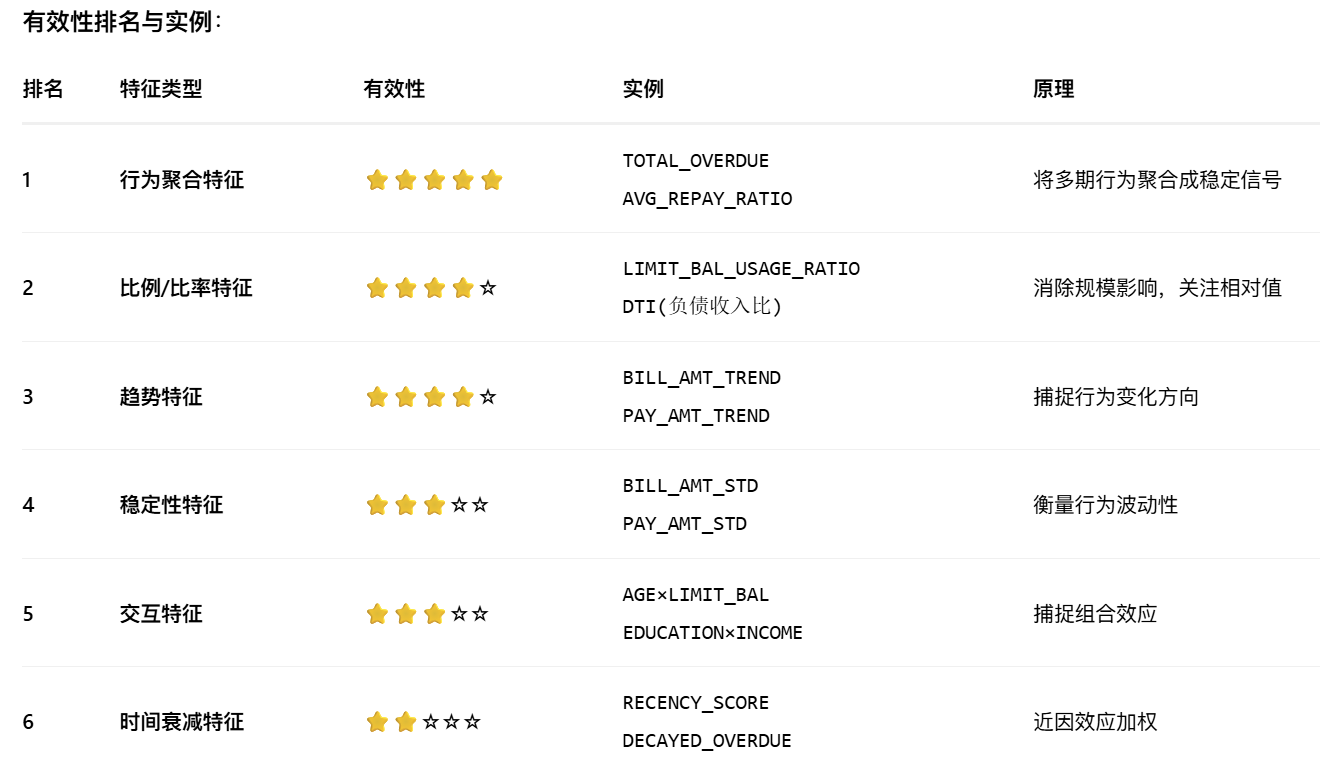

In [21]:
# 1. 逾期行为聚合特征
def create_overdue_features(df):
    """创建逾期相关聚合特征"""
    pay_cols = [f'PAY_{i}' for i in range(0, 7)]  # PAY_0到PAY_6

    # 逾期严重程度加权
    df['OVERDUE_WEIGHTED'] = 0
    weights = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

    for col in pay_cols:
        if col in df.columns:
            df['OVERDUE_WEIGHTED'] += df[col].map(lambda x: weights.get(x, 0) if x >= 1 else 0)

    # 最长连续逾期月数
    def max_consecutive_overdue(row):
        max_streak = 0
        current_streak = 0
        for col in pay_cols:
            if col in df.columns and row[col] >= 1:
                current_streak += 1
                max_streak = max(max_streak, current_streak)
            else:
                current_streak = 0
        return max_streak

    df['MAX_CONSECUTIVE_OVERDUE'] = df.apply(max_consecutive_overdue, axis=1)

    return df

# 2. 还款稳定性特征
def create_repayment_stability(df):
    """创建还款稳定性特征"""
    pay_amt_cols = [f'PAY_AMT{i}' for i in range(1, 7)]

    if all(col in df.columns for col in pay_amt_cols):
        # 变异系数 = 标准差/均值
        df['PAY_AMT_CV'] = df[pay_amt_cols].std(axis=1) / (df[pay_amt_cols].mean(axis=1) + 1e-6)

        # 零还款月数占比
        df['ZERO_PAYMENT_RATIO'] = (df[pay_amt_cols] == 0).sum(axis=1) / len(pay_amt_cols)

        # 还款模式变化
        df['PAYMENT_PATTERN_CHANGE'] = (df['PAY_AMT1'] - df['PAY_AMT6']).abs() / (df[['PAY_AMT1', 'PAY_AMT6']].mean(axis=1) + 1e-6)

    return df

# 3. 额度使用行为特征
def create_limit_usage_features(df):
    """创建额度使用相关特征"""
    if 'LIMIT_BAL' in df.columns and 'BILL_AMT1' in df.columns:
        # 额度使用率
        df['LIMIT_USAGE_RATE'] = df['BILL_AMT1'] / (df['LIMIT_BAL'] + 1e-6)

        # 额度使用趋势
        bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
        if all(col in df.columns for col in bill_cols):
            # 最近3个月平均使用率
            recent_bills = bill_cols[:3]
            df['RECENT_USAGE_RATE'] = df[recent_bills].mean(axis=1) / (df['LIMIT_BAL'] + 1e-6)

            # 使用率波动
            usage_rates = df[bill_cols].div(df['LIMIT_BAL'] + 1e-6, axis=0)
            df['USAGE_VOLATILITY'] = usage_rates.std(axis=1)

    return df

3. 模型评估

3.1 除了AUC，还应该关注哪些指标？为什么？
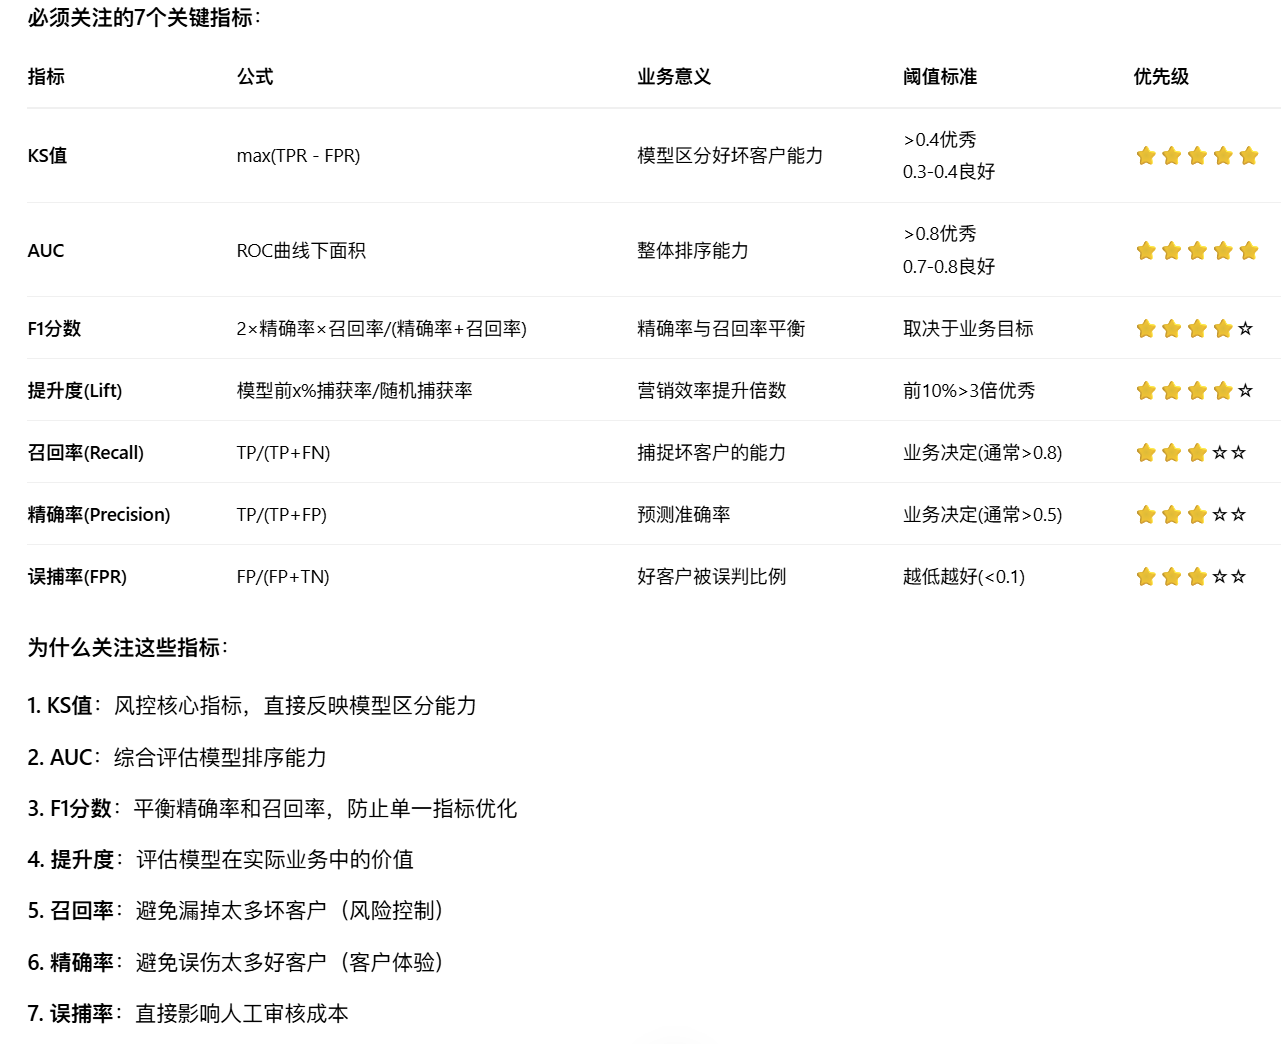

=== 综合模型评估 ===
准确率: 0.8173
精确率: 0.6632
召回率: 0.3541
F1分数: 0.4617
AUC: 0.7795
KS值: 0.4235
提升度: 3.1391
AP: 0.5513
捕捉率: 0.3541
误捕率: 0.0511
查全率: 0.3541
查准率: 0.6632


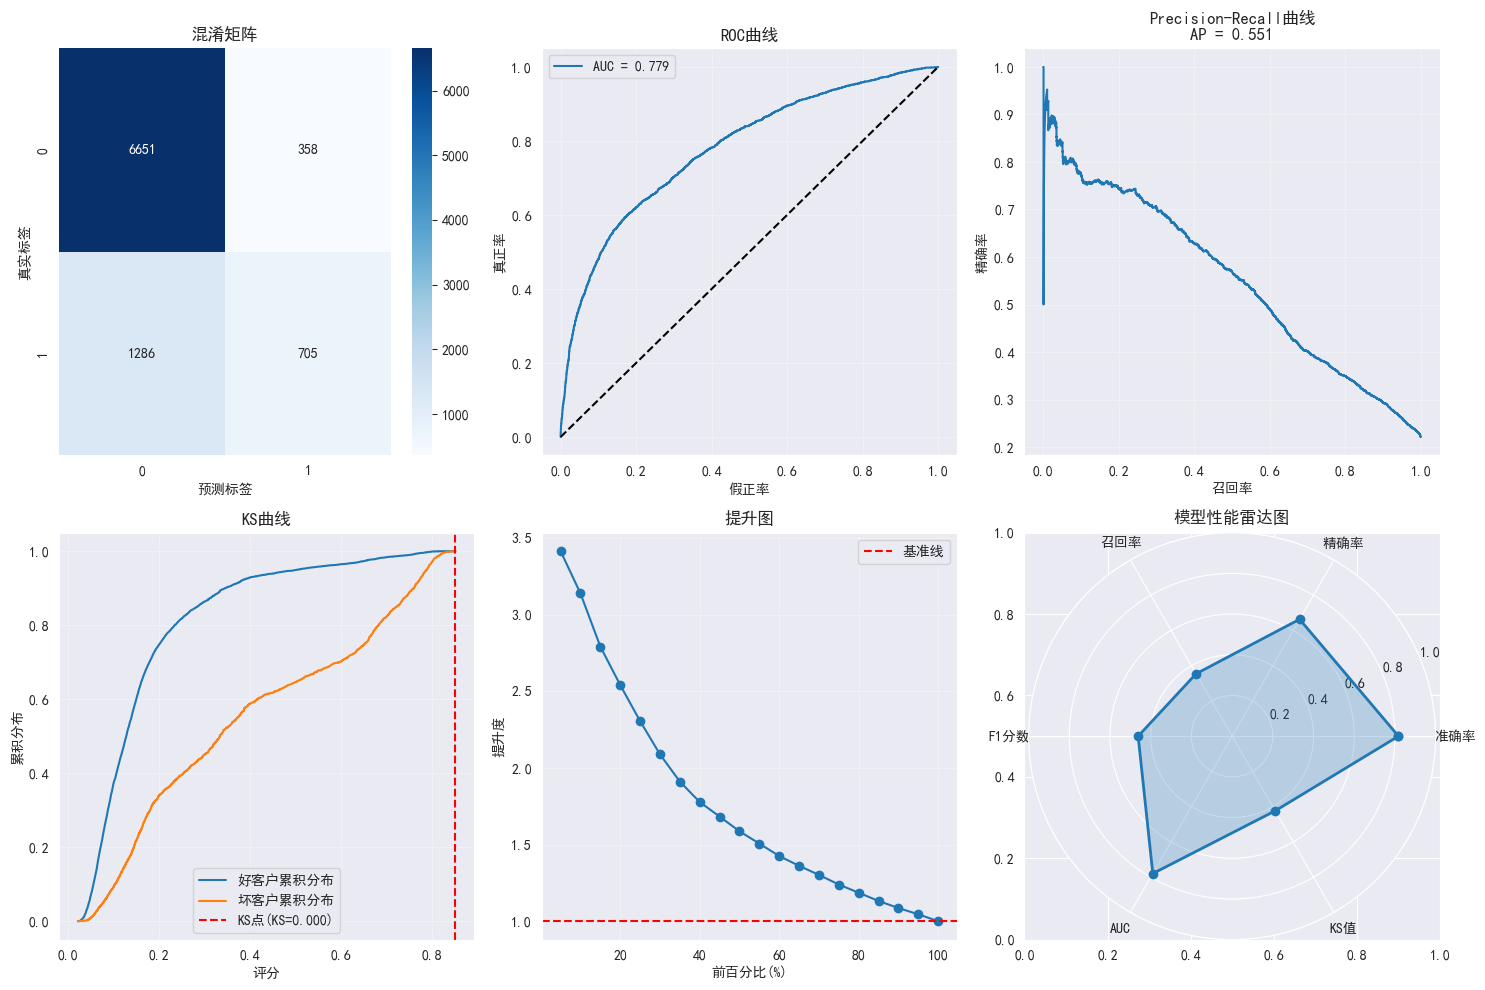

In [22]:
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
import numpy as np

def comprehensive_evaluation(y_true, y_pred, y_pred_proba, model_name="模型"):
    """综合评估函数"""

    # 基础指标
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 计算各种指标
    metrics = {
        '准确率': (tp + tn) / (tp + tn + fp + fn),
        '精确率': tp / (tp + fp) if (tp + fp) > 0 else 0,
        '召回率': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'F1分数': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'AUC': roc_auc_score(y_true, y_pred_proba),
        'KS值': calculate_ks(y_true, y_pred_proba),
        '提升度': calculate_lift(y_true, y_pred_proba, top_percent=0.1),
        'AP': average_precision_score(y_true, y_pred_proba)  # Average Precision
    }

    # 业务指标
    total_customers = len(y_true)
    fraud_customers = sum(y_true)
    metrics.update({
        '捕捉率': tp / fraud_customers if fraud_customers > 0 else 0,
        '误捕率': fp / (total_customers - fraud_customers) if (total_customers - fraud_customers) > 0 else 0,
        '查全率': tp / fraud_customers if fraud_customers > 0 else 0,
        '查准率': tp / (tp + fp) if (tp + fp) > 0 else 0
    })

    return metrics

def calculate_ks(y_true, y_pred_proba):
    """计算KS值"""
    from scipy.stats import ks_2samp
    good_scores = y_pred_proba[y_true == 0]
    bad_scores = y_pred_proba[y_true == 1]
    ks_stat, _ = ks_2samp(bad_scores, good_scores)
    return ks_stat

def calculate_lift(y_true, y_pred_proba, top_percent=0.1):
    """计算提升度"""
    # 按预测概率排序
    df_temp = pd.DataFrame({'true': y_true, 'pred': y_pred_proba})
    df_temp = df_temp.sort_values('pred', ascending=False)

    # 计算top n%的捕获率
    n_top = int(len(df_temp) * top_percent)
    top_capture = df_temp.iloc[:n_top]['true'].sum()
    overall_capture = df_temp['true'].sum()

    # 提升度 = (top n%的捕获率) / (随机选择的捕获率)
    lift = (top_capture / n_top) / (overall_capture / len(df_temp))
    return lift

# 使用示例
print("=== 综合模型评估 ===")
metrics = comprehensive_evaluation(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost模型")

for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

# 绘制多维度评估图
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. 混淆矩阵热图
ax1 = axes[0, 0]
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('混淆矩阵')
ax1.set_xlabel('预测标签')
ax1.set_ylabel('真实标签')

# 2. ROC曲线
ax2 = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
ax2.plot(fpr, tpr, label=f'AUC = {metrics["AUC"]:.3f}')
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('假正率')
ax2.set_ylabel('真正率')
ax2.set_title('ROC曲线')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall曲线
ax3 = axes[0, 2]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
ax3.plot(recall, precision)
ax3.set_xlabel('召回率')
ax3.set_ylabel('精确率')
ax3.set_title(f'Precision-Recall曲线\nAP = {metrics["AP"]:.3f}')
ax3.grid(True, alpha=0.3)

# 4. KS曲线
ax4 = axes[1, 0]
# 计算累积分布
df_temp = pd.DataFrame({'score': y_pred_proba_xgb, 'label': y_test})
df_temp = df_temp.sort_values('score')
df_temp['cum_good'] = (df_temp['label'] == 0).cumsum() / (df_temp['label'] == 0).sum()
df_temp['cum_bad'] = (df_temp['label'] == 1).cumsum() / (df_temp['label'] == 1).sum()
df_temp['ks'] = df_temp['cum_bad'] - df_temp['cum_good']

ks_value = df_temp['ks'].max()
ks_cutoff = df_temp.loc[df_temp['ks'].idxmax(), 'score']

ax4.plot(df_temp['score'], df_temp['cum_good'], label='好客户累积分布')
ax4.plot(df_temp['score'], df_temp['cum_bad'], label='坏客户累积分布')
ax4.axvline(x=ks_cutoff, color='red', linestyle='--', label=f'KS点(KS={ks_value:.3f})')
ax4.set_xlabel('评分')
ax4.set_ylabel('累积分布')
ax4.set_title('KS曲线')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. 提升图
ax5 = axes[1, 1]
# 计算不同分位数的提升度
quantiles = np.arange(0.05, 1.05, 0.05)
lifts = []
for q in quantiles:
    lift = calculate_lift(y_test, y_pred_proba_xgb, top_percent=q)
    lifts.append(lift)

ax5.plot(quantiles * 100, lifts, marker='o')
ax5.axhline(y=1, color='red', linestyle='--', label='基准线')
ax5.set_xlabel('前百分比(%)')
ax5.set_ylabel('提升度')
ax5.set_title('提升图')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. 指标对比雷达图
ax6 = axes[1, 2]
radar_metrics = ['准确率', '精确率', '召回率', 'F1分数', 'AUC', 'KS值']
radar_values = [metrics[m] for m in radar_metrics]

# 标准化到0-1范围
max_values = [1, 1, 1, 1, 1, 1]  # 这些指标的最大值都是1
normalized_values = [v/max_v for v, max_v in zip(radar_values, max_values)]

angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
angles += angles[:1]  # 闭合图形
normalized_values += normalized_values[:1]

ax6 = plt.subplot(236, projection='polar')
ax6.plot(angles, normalized_values, 'o-', linewidth=2)
ax6.fill(angles, normalized_values, alpha=0.25)
ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(radar_metrics)
ax6.set_ylim(0, 1)
ax6.set_title('模型性能雷达图')
ax6.grid(True)

plt.tight_layout()
plt.show()

3.2 如何平衡召回率和精确率？

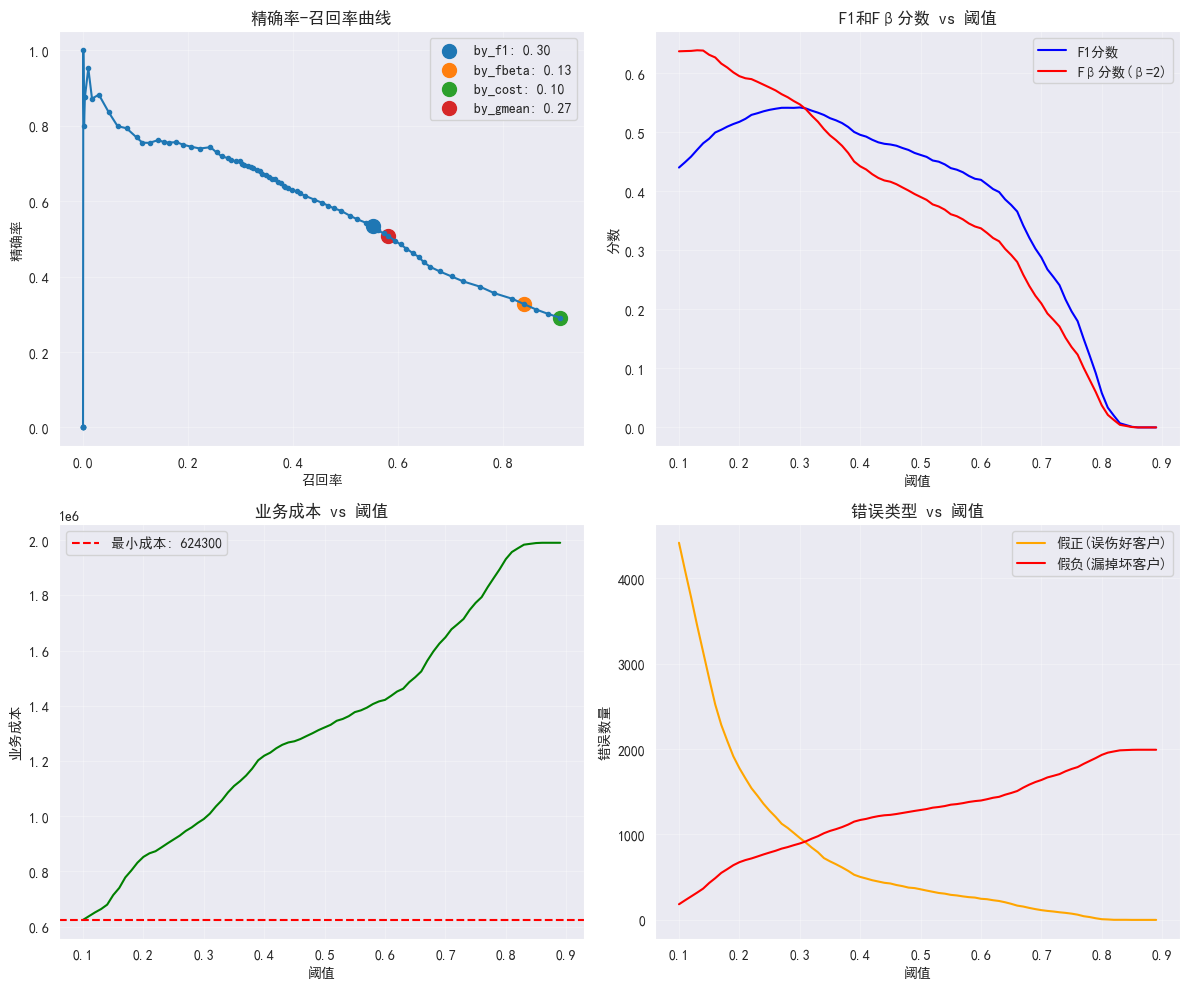

=== 最优阈值选择建议 ===

by_f1策略:
  最优阈值: 0.300
  精确率: 0.534, 召回率: 0.551
  F1分数: 0.542, 业务成本: 989900
  TP: 1097.0, FP: 959.0, FN: 894.0, TN: 6050.0

by_fbeta策略:
  最优阈值: 0.130
  精确率: 0.327, 召回率: 0.840
  F1分数: 0.470, 业务成本: 663700
  TP: 1672.0, FP: 3447.0, FN: 319.0, TN: 3562.0

by_cost策略:
  最优阈值: 0.100
  精确率: 0.291, 召回率: 0.908
  F1分数: 0.440, 业务成本: 624300
  TP: 1808.0, FP: 4413.0, FN: 183.0, TN: 2596.0

by_gmean策略:
  最优阈值: 0.270
  精确率: 0.507, 召回率: 0.581
  F1分数: 0.542, 业务成本: 946500
  TP: 1157.0, FP: 1125.0, FN: 834.0, TN: 5884.0

=== 业务策略建议 ===

1. 风险厌恶型策略（重视召回率）:  tpr = tp / (tp + fn)
   - 场景: 高风险业务，如大额贷款
   - 策略: 选择较低阈值(如0.3-0.4)，提高召回率
   - 代价: 误报率增加，人工审核成本上升

2. 成本优化型策略（平衡成本）:
   - 场景: 零售信贷，注重运营效率
   - 策略: 选择成本最小化的阈值(如0.5-0.6)
   - 代价: 可能漏掉部分坏客户

3. 客户体验型策略（重视精确率）:   tp = tp / (tp + fp)
   - 场景: 优质客户服务，避免误伤
   - 策略: 选择较高阈值(如0.7-0.8)，降低误报
   - 代价: 可能漏掉较多坏客户

4. 动态阈值策略:
   - 根据客户价值调整阈值
   - 高价值客户: 使用较高阈值，避免误伤
   - 低价值客户: 使用较低阈值，严格风控



In [23]:
def find_optimal_threshold(y_true, y_pred_proba, cost_matrix=None):
    """
    寻找最优阈值

    参数：
    y_true: 真实标签
    y_pred_proba: 预测概率
    cost_matrix: 成本矩阵 [TN_cost, FP_cost, FN_cost, TP_cost]
    """

    thresholds = np.arange(0.1, 0.9, 0.01)
    results = []

    if cost_matrix is None:
        # 默认成本矩阵：假负(漏掉坏客户)成本 > 假正(误伤好客户)成本
        # 假设：漏掉一个坏客户损失1000元，误伤一个好客户损失100元
        cost_matrix = [0, 100, 1000, 0]  # [TN, FP, FN, TP]

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # 计算指标
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # 计算业务成本
        cost = (tn * cost_matrix[0] + fp * cost_matrix[1] +
                fn * cost_matrix[2] + tp * cost_matrix[3])

        # Fβ分数，β决定召回率权重
        beta = 2  # 更重视召回率
        f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0

        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f_beta': f_beta,
            'cost': cost,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'tn': tn
        })

    df_results = pd.DataFrame(results)

    # 不同策略的最优阈值
    optimal_by_f1 = df_results.loc[df_results['f1'].idxmax()]
    optimal_by_fbeta = df_results.loc[df_results['f_beta'].idxmax()]
    optimal_by_cost = df_results.loc[df_results['cost'].idxmin()]
    optimal_by_geometric_mean = df_results.loc[(df_results['precision'] * df_results['recall']).idxmax()]

    return df_results, {
        'by_f1': optimal_by_f1,
        'by_fbeta': optimal_by_fbeta,
        'by_cost': optimal_by_cost,
        'by_gmean': optimal_by_geometric_mean
    }

# 寻找最优阈值
df_thresholds, optimal_thresholds = find_optimal_threshold(y_test, y_pred_proba_xgb)

# 可视化阈值选择
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. 精确率-召回率曲线
ax1 = axes[0, 0]
ax1.plot(df_thresholds['recall'], df_thresholds['precision'], marker='.')
ax1.set_xlabel('召回率')
ax1.set_ylabel('精确率')
ax1.set_title('精确率-召回率曲线')
ax1.grid(True, alpha=0.3)

# 标记最优阈值点
for strategy, opt in optimal_thresholds.items():
    ax1.scatter(opt['recall'], opt['precision'], s=100, label=f"{strategy}: {opt['threshold']:.2f}")

ax1.legend()

# 2. F1分数 vs 阈值
ax2 = axes[0, 1]
ax2.plot(df_thresholds['threshold'], df_thresholds['f1'], label='F1分数', color='blue')
ax2.plot(df_thresholds['threshold'], df_thresholds['f_beta'], label='Fβ分数(β=2)', color='red')
ax2.set_xlabel('阈值')
ax2.set_ylabel('分数')
ax2.set_title('F1和Fβ分数 vs 阈值')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 业务成本 vs 阈值
ax3 = axes[1, 0]
ax3.plot(df_thresholds['threshold'], df_thresholds['cost'], color='green')
ax3.axhline(y=optimal_thresholds['by_cost']['cost'], color='red', linestyle='--',
           label=f"最小成本: {optimal_thresholds['by_cost']['cost']:.0f}")
ax3.set_xlabel('阈值')
ax3.set_ylabel('业务成本')
ax3.set_title('业务成本 vs 阈值')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 不同类型错误 vs 阈值
ax4 = axes[1, 1]
ax4.plot(df_thresholds['threshold'], df_thresholds['fp'], label='假正(误伤好客户)', color='orange')
ax4.plot(df_thresholds['threshold'], df_thresholds['fn'], label='假负(漏掉坏客户)', color='red')
ax4.set_xlabel('阈值')
ax4.set_ylabel('错误数量')
ax4.set_title('错误类型 vs 阈值')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 输出最优阈值建议
print("=== 最优阈值选择建议 ===")
for strategy, opt in optimal_thresholds.items():
    print(f"\n{strategy}策略:")
    print(f"  最优阈值: {opt['threshold']:.3f}")
    print(f"  精确率: {opt['precision']:.3f}, 召回率: {opt['recall']:.3f}")
    print(f"  F1分数: {opt['f1']:.3f}, 业务成本: {opt['cost']:.0f}")
    print(f"  TP: {opt['tp']}, FP: {opt['fp']}, FN: {opt['fn']}, TN: {opt['tn']}")

# 业务策略建议
print("\n=== 业务策略建议 ===")
print("""
1. 风险厌恶型策略（重视召回率）:  tpr = tp / (tp + fn)
   - 场景: 高风险业务，如大额贷款
   - 策略: 选择较低阈值(如0.3-0.4)，提高召回率
   - 代价: 误报率增加，人工审核成本上升

2. 成本优化型策略（平衡成本）:
   - 场景: 零售信贷，注重运营效率
   - 策略: 选择成本最小化的阈值(如0.5-0.6)
   - 代价: 可能漏掉部分坏客户

3. 客户体验型策略（重视精确率）:   tp = tp / (tp + fp)
   - 场景: 优质客户服务，避免误伤
   - 策略: 选择较高阈值(如0.7-0.8)，降低误报
   - 代价: 可能漏掉较多坏客户

4. 动态阈值策略:
   - 根据客户价值调整阈值
   - 高价值客户: 使用较高阈值，避免误伤
   - 低价值客户: 使用较低阈值，严格风控
""")

In [24]:
'''
平衡策略总结：
1、基于业务目标调整：
反欺诈：高召回率优先（宁可错杀，不可放过）   tpr = tp / (tp + fn)
信用审批：精确率优先（避免误拒好客户）    tp = tp / (tp + fp)
营销响应：F1分数优先（平衡两者）

2、使用成本敏感学习：
# 为不同错误类型分配不同成本
cost_matrix = {
    'TN': 0,    # 正确拒绝：无成本
    'FP': 100,  # 误伤好客户：客户流失成本
    'FN': 1000, # 漏掉坏客户：坏账损失
    'TP': -500  # 正确捕捉：可能避免的损失（负成本）
}

3、分群差异化策略：
高价值客户群：提高阈值，降低误报
高风险客群：降低阈值，提高召回
新客户：谨慎策略，中等阈值

4、动态阈值调整：
根据业务周期调整
根据模型表现动态优化
A/B测试寻找最优阈值


'''

"\n平衡策略总结：\n1、基于业务目标调整：\n反欺诈：高召回率优先（宁可错杀，不可放过）   tpr = tp / (tp + fn)\n信用审批：精确率优先（避免误拒好客户）    tp = tp / (tp + fp)\n营销响应：F1分数优先（平衡两者）\n\n2、使用成本敏感学习：\n# 为不同错误类型分配不同成本\ncost_matrix = {\n    'TN': 0,    # 正确拒绝：无成本\n    'FP': 100,  # 误伤好客户：客户流失成本\n    'FN': 1000, # 漏掉坏客户：坏账损失\n    'TP': -500  # 正确捕捉：可能避免的损失（负成本）\n}\n\n3、分群差异化策略：\n高价值客户群：提高阈值，降低误报\n高风险客群：降低阈值，提高召回\n新客户：谨慎策略，中等阈值\n\n4、动态阈值调整：\n根据业务周期调整\n根据模型表现动态优化\nA/B测试寻找最优阈值\n\n\n"

4. 改进方向

4.1 还可以创建哪些有业务意义的特征？



In [25]:
'''
10个有潜力的高级特征：
1、行为突变指数：消费/还款模式的突然变化
2、循环信用依赖度：是否依赖循环信用维持现金流
3、季节性消费模式：消费是否存在规律性波动
4、额度使用波动性：额度使用率的稳定性
5、还款压力指数：还款金额占额度的比例
6、信用历史质量：基于历史行为的信用评分
7、交叉验证特征：多维度信息的一致性验证
8、趋势加速度：消费/还款变化的加速度
9、行为熵：行为模式的随机性/规律性
10同侪对比特征：与同年龄段/职业群体的对比
'''

'\n10个有潜力的高级特征：\n1、行为突变指数：消费/还款模式的突然变化\n2、循环信用依赖度：是否依赖循环信用维持现金流\n3、季节性消费模式：消费是否存在规律性波动\n4、额度使用波动性：额度使用率的稳定性\n5、还款压力指数：还款金额占额度的比例\n6、信用历史质量：基于历史行为的信用评分\n7、交叉验证特征：多维度信息的一致性验证\n8、趋势加速度：消费/还款变化的加速度\n9、行为熵：行为模式的随机性/规律性\n10同侪对比特征：与同年龄段/职业群体的对比\n'

In [26]:
def create_advanced_features(df):
    """创建高级业务特征"""

    advanced_features = pd.DataFrame(index=df.index)

    # 1. 行为一致性特征
    # 还款行为是否稳定
    pay_status_cols = [f'PAY_{i}' for i in range(0, 7) if f'PAY_{i}' in df.columns]
    if len(pay_status_cols) > 1:
        # 还款状态变化频率
        advanced_features['PAY_STATUS_CHANGE_FREQ'] = df[pay_status_cols].diff(axis=1).abs().sum(axis=1) / len(pay_status_cols)

        # 是否总是全额还款
        advanced_features['ALWAYS_FULL_PAYMENT'] = (df[pay_status_cols] == -1).all(axis=1).astype(int)

        # 是否有过逾期
        advanced_features['EVER_OVERDUE'] = (df[pay_status_cols] >= 1).any(axis=1).astype(int)

    # 2. 消费模式特征
    bill_cols = [f'BILL_AMT{i}' for i in range(1, 7) if f'BILL_AMT{i}' in df.columns]
    if len(bill_cols) > 1:
        # 消费季节性
        advanced_features['BILL_SEASONALITY'] = df[bill_cols].std(axis=1) / (df[bill_cols].mean(axis=1) + 1e-6)

        # 消费增长趋势
        x = np.arange(len(bill_cols))
        def linear_trend(row):
            if row.notnull().all():
                slope, _ = np.polyfit(x, row.values, 1)
                return slope
            return 0

        advanced_features['BILL_TREND_SLOPE'] = df[bill_cols].apply(linear_trend, axis=1)

    # 3. 还款能力特征
    if 'LIMIT_BAL' in df.columns and 'BILL_AMT1' in df.columns:
        # 额度充足率
        advanced_features['CREDIT_SUFFICIENCY'] = (df['LIMIT_BAL'] - df['BILL_AMT1']) / (df['LIMIT_BAL'] + 1e-6)

        # 还款压力指数
        pay_amt_cols = [f'PAY_AMT{i}' for i in range(1, 7) if f'PAY_AMT{i}' in df.columns]
        if len(pay_amt_cols) > 0:
            avg_payment = df[pay_amt_cols].mean(axis=1)
            advanced_features['REPAYMENT_PRESSURE'] = avg_payment / (df['LIMIT_BAL'] + 1e-6)

    # 4. 行为突变特征
    if len(bill_cols) >= 2:
        # 最近一个月消费突变
        advanced_features['BILL_LAST_MONTH_CHANGE'] = (df['BILL_AMT1'] - df['BILL_AMT2']).abs() / (df['BILL_AMT2'] + 1e-6)

        # 消费突变标志
        advanced_features['BILL_SPIKE_FLAG'] = (advanced_features['BILL_LAST_MONTH_CHANGE'] > 0.5).astype(int)

    # 5. 交叉特征
    if 'AGE' in df.columns and 'LIMIT_BAL' in df.columns:
        # 年龄标准化额度
        age_bins = [20, 30, 40, 50, 60, 100]
        age_labels = ['20-29', '30-39', '40-49', '50-59', '60+']
        df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)

        # 计算各年龄段平均额度
        avg_limit_by_age = df.groupby('AGE_GROUP')['LIMIT_BAL'].mean()

        # 额度相对值
        def relative_limit(row):
            if pd.notnull(row['AGE_GROUP']):
                return row['LIMIT_BAL'] / avg_limit_by_age[row['AGE_GROUP']]
            return 1

        advanced_features['RELATIVE_LIMIT_BY_AGE'] = df.apply(relative_limit, axis=1)

    # 6. 时间序列特征（假设数据是时间顺序的）
    if len(bill_cols) >= 3:
        # 移动平均
        advanced_features['BILL_3M_MA'] = df[bill_cols[:3]].mean(axis=1)

        # 同比变化
        advanced_features['BILL_YOY_CHANGE'] = (df['BILL_AMT1'] - df['BILL_AMT2']).abs() / (df['BILL_AMT2'] + 1e-6)

    # 7. 风险集中度特征
    if all(col in df.columns for col in ['BILL_AMT1', 'PAY_AMT1']):
        # 当期还款压力
        advanced_features['CURRENT_REPAYMENT_PRESSURE'] = df['PAY_AMT1'] / (df['BILL_AMT1'] + 1e-6)

        # 循环信用依赖度
        pay_status_0 = df['PAY_0'] if 'PAY_0' in df.columns else 0
        advanced_features['REVOLVING_CREDIT_DEPENDENCY'] = (pay_status_0 == 0).astype(int)

    return advanced_features

# 创建高级特征
advanced_features = create_advanced_features(df)
print(f"创建了 {advanced_features.shape[1]} 个高级业务特征")
print("\n高级特征示例:")
for i, col in enumerate(advanced_features.columns[:10], 1):
    print(f"{i:2d}. {col}: {advanced_features[col].describe()['mean']:.4f}")

创建了 14 个高级业务特征

高级特征示例:
 1. PAY_STATUS_CHANGE_FREQ: 0.2608
 2. ALWAYS_FULL_PAYMENT: 0.0664
 3. EVER_OVERDUE: 0.3356
 4. BILL_SEASONALITY: 61935.2725
 5. BILL_TREND_SLOPE: -2631.7452
 6. CREDIT_SUFFICIENCY: 0.5762
 7. REPAYMENT_PRESSURE: 0.0389
 8. BILL_LAST_MONTH_CHANGE: 528640795.7674
 9. BILL_SPIKE_FLAG: 0.2359
10. RELATIVE_LIMIT_BY_AGE: 1.0000


4.2 如何处理类别不平衡问题？

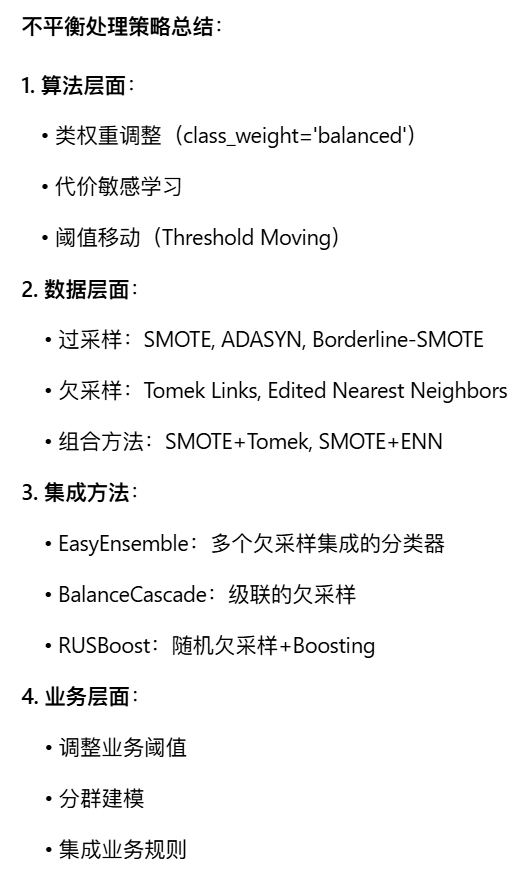

原始数据分布: Counter({0: 23364, 1: 6636})
正负样本比例: 0.284

=== 使用 原始数据 ===
错误: 'NoneType' object has no attribute 'fit_resample'

=== 使用 随机过采样 ===
处理后分布: Counter({1: 23364, 0: 23364})
错误: could not convert string to float: '中年(30-50)'

=== 使用 SMOTE ===
错误: could not convert string to float: '青年(<30)'

=== 使用 ADASYN ===
错误: could not convert string to float: '青年(<30)'

=== 使用 随机欠采样 ===
处理后分布: Counter({0: 6636, 1: 6636})
错误: could not convert string to float: '中年(30-50)'

=== 使用 Tomek Links ===
错误: could not convert string to float: '青年(<30)'

=== 使用 SMOTE+Tomek ===
错误: could not convert string to float: '青年(<30)'

=== 使用 SMOTE+ENN ===
错误: could not convert string to float: '青年(<30)'


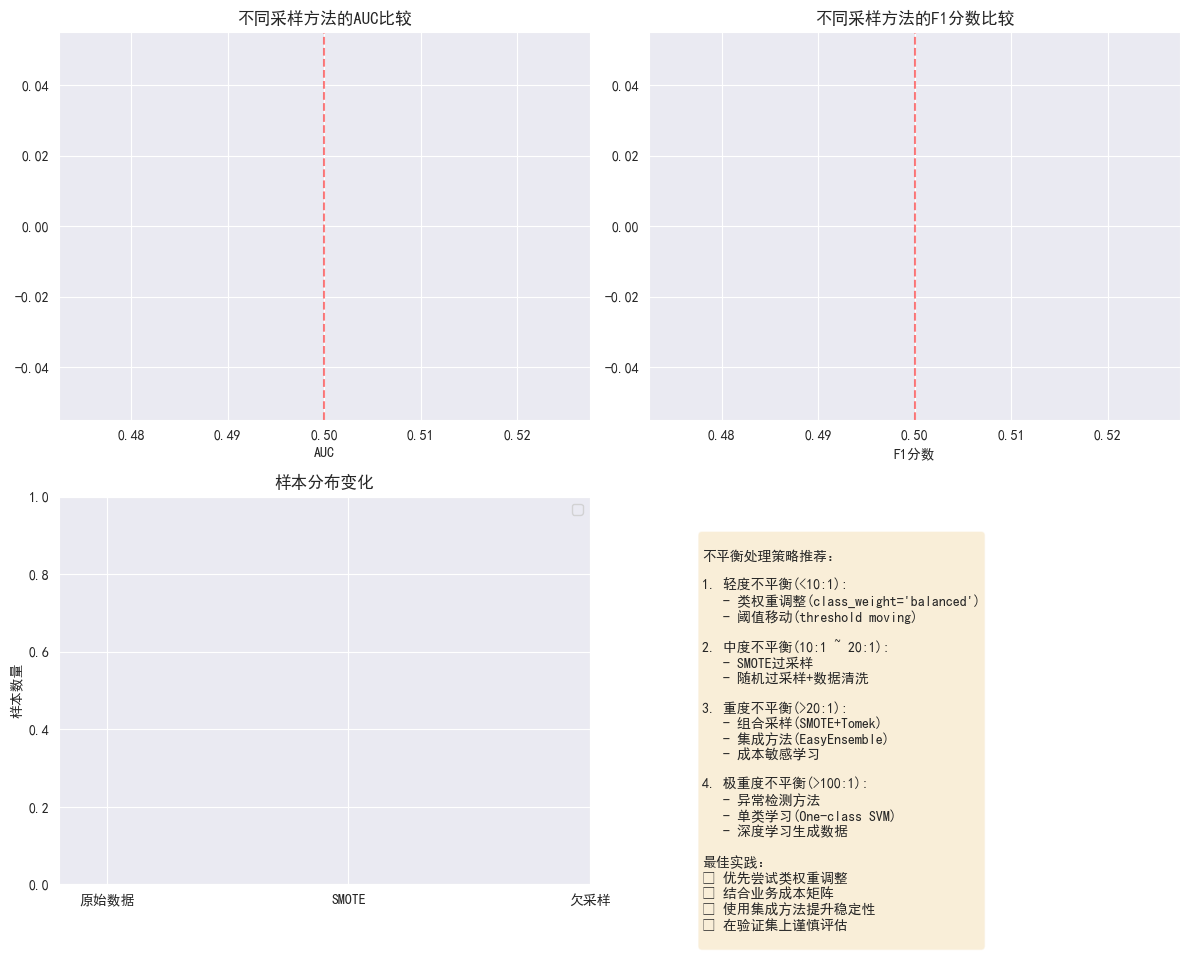

=== 信用卡违约数据的不平衡处理实践 ===
正负样本比例: 1:3.5
情况: 轻度不平衡
建议: 类权重调整 或 阈值移动

=== 类权重调整示例 ===
类别权重: 类别0=0.64, 类别1=2.26

=== 阈值移动示例 ===
默认阈值: 0.5
最优阈值: 0.459
F1分数提升: 0.0036


In [27]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

def evaluate_imbalance_methods(X, y, methods):
    """评估不同不平衡处理方法"""

    results = {}

    # 原始数据分布
    print(f"原始数据分布: {Counter(y)}")
    print(f"正负样本比例: {sum(y==1)/sum(y==0):.3f}")

    for method_name, sampler in methods.items():
        print(f"\n=== 使用 {method_name} ===")

        try:
            # 应用采样方法
            X_resampled, y_resampled = sampler.fit_resample(X, y)
            print(f"处理后分布: {Counter(y_resampled)}")

            # 训练模型
            X_train, X_test, y_train, y_test = train_test_split(
                X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
            )

            # 使用更简单的模型快速评估
            from sklearn.linear_model import LogisticRegression
            model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # 计算评估指标
            from sklearn.metrics import classification_report, roc_auc_score, f1_score

            auc = roc_auc_score(y_test, y_pred_proba)
            f1 = f1_score(y_test, y_pred)

            results[method_name] = {
                'auc': auc,
                'f1': f1,
                'distribution': dict(Counter(y_resampled))
            }

            print(f"AUC: {auc:.4f}, F1: {f1:.4f}")

        except Exception as e:
            print(f"错误: {e}")
            results[method_name] = None

    return results

# 准备数据
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# 定义不同的不平衡处理方法
imbalance_methods = {
    '原始数据': None,
    '随机过采样': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    '随机欠采样': RandomUnderSampler(random_state=42),
    'Tomek Links': TomekLinks(),
    'SMOTE+Tomek': SMOTETomek(random_state=42),
    'SMOTE+ENN': SMOTEENN(random_state=42)
}

# 评估不同方法
results = evaluate_imbalance_methods(X, y, imbalance_methods)

# 可视化比较
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. AUC比较
ax1 = axes[0, 0]
methods = [m for m in results.keys() if results[m] is not None]
auc_scores = [results[m]['auc'] for m in methods if m in results]
ax1.barh(methods, auc_scores, color='skyblue')
ax1.set_xlabel('AUC')
ax1.set_title('不同采样方法的AUC比较')
ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)

# 2. F1分数比较
ax2 = axes[0, 1]
f1_scores = [results[m]['f1'] for m in methods if m in results]
ax2.barh(methods, f1_scores, color='lightgreen')
ax2.set_xlabel('F1分数')
ax2.set_title('不同采样方法的F1分数比较')
ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)

# 3. 样本分布
ax3 = axes[1, 0]
for idx, method in enumerate(['原始数据', 'SMOTE', '随机欠采样']):
    if method in results and results[method] is not None:
        dist = results[method]['distribution']
        if method == '原始数据':
            labels = ['好客户', '坏客户']
            sizes = [dist[0], dist[1]]
        else:
            sizes = [dist[0], dist[1]]
        ax3.bar([idx*2, idx*2+0.8], sizes, width=0.8, label=method)
ax3.set_xticks([0.4, 2.4, 4.4])
ax3.set_xticklabels(['原始数据', 'SMOTE', '欠采样'])
ax3.set_ylabel('样本数量')
ax3.set_title('样本分布变化')
ax3.legend()

# 4. 推荐策略
ax4 = axes[1, 1]
ax4.axis('off')
recommendations = """
不平衡处理策略推荐：

1. 轻度不平衡(<10:1):
   - 类权重调整(class_weight='balanced')
   - 阈值移动(threshold moving)

2. 中度不平衡(10:1 ~ 20:1):
   - SMOTE过采样
   - 随机过采样+数据清洗

3. 重度不平衡(>20:1):
   - 组合采样(SMOTE+Tomek)
   - 集成方法(EasyEnsemble)
   - 成本敏感学习

4. 极重度不平衡(>100:1):
   - 异常检测方法
   - 单类学习(One-class SVM)
   - 深度学习生成数据

最佳实践：
• 优先尝试类权重调整
• 结合业务成本矩阵
• 使用集成方法提升稳定性
• 在验证集上谨慎评估
"""
ax4.text(0.1, 0.9, recommendations, transform=ax4.transAxes,
         verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 实际应用建议
print("=== 信用卡违约数据的不平衡处理实践 ===")
print(f"正负样本比例: 1:{sum(y==0)/sum(y==1):.1f}")

if sum(y==1)/len(y) < 0.01:
    print("情况: 极重度不平衡（违约率<1%）")
    print("建议: 使用异常检测或代价敏感学习")
elif sum(y==1)/len(y) < 0.05:
    print("情况: 重度不平衡（违约率1%-5%）")
    print("建议: SMOTE+Tomek 或 EasyEnsemble")
elif sum(y==1)/len(y) < 0.2:
    print("情况: 中度不平衡（违约率5%-20%）")
    print("建议: SMOTE过采样 或 类权重调整")
else:
    print("情况: 轻度不平衡")
    print("建议: 类权重调整 或 阈值移动")

# 类权重调整示例
print("\n=== 类权重调整示例 ===")
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y)
class_weights = compute_class_weight('balanced', classes=classes, y=y)
print(f"类别权重: 类别0={class_weights[0]:.2f}, 类别1={class_weights[1]:.2f}")

# 训练带权重的模型
model_weighted = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight={0: class_weights[0], 1: class_weights[1]}
)
model_weighted.fit(X_train, y_train)

# 阈值移动示例
print("\n=== 阈值移动示例 ===")
# 计算最优阈值
from sklearn.metrics import precision_recall_curve
y_pred_proba = model_weighted.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 找到最优阈值（最大化F1分数）
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"默认阈值: 0.5")
print(f"最优阈值: {optimal_threshold:.3f}")
print(f"F1分数提升: {f1_scores[optimal_idx] - f1_scores[len(f1_scores)//2]:.4f}")

5. 业务应用

5.1 如何将这个模型应用到实际业务中？


In [28]:
class CreditRiskModelDeployer:
    """信用风险模型部署器"""

    def __init__(self, model, features, feature_processor=None):
        self.model = model
        self.features = features
        self.feature_processor = feature_processor
        self.threshold = 0.5  # 默认阈值
        self.scorecard = None

    def set_threshold(self, threshold):
        """设置决策阈值"""
        self.threshold = threshold

    def predict_proba(self, X):
        """预测概率"""
        if self.feature_processor:
            X_processed = self.feature_processor.transform(X)
        else:
            X_processed = X[self.features]
        return self.model.predict_proba(X_processed)

    def predict(self, X):
        """预测类别"""
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_with_reason(self, X_raw):
        """带解释的预测"""
        # 预测概率
        proba = self.predict_proba(X_raw)[:, 1]
        predictions = (proba >= self.threshold).astype(int)

        # 特征贡献度分析
        if hasattr(self.model, 'feature_importances_'):
            importances = self.model.feature_importances_
            feature_importance = dict(zip(self.features, importances))
        else:
            # 对于非树模型，使用系数绝对值
            if hasattr(self.model, 'coef_'):
                importances = np.abs(self.model.coef_[0])
                feature_importance = dict(zip(self.features, importances))
            else:
                feature_importance = None

        # 生成解释
        explanations = []
        for idx, (prob, pred) in enumerate(zip(proba, predictions)):
            explanation = {
                'probability': float(prob),
                'prediction': int(pred),
                'decision': '拒绝' if pred == 1 else '通过',
                'key_factors': []
            }

            if feature_importance and idx == 0:  # 只分析第一个样本
                # 找出最重要的特征及其值
                top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:5]
                for feat, imp in top_features:
                    if feat in X_raw.columns:
                        feat_value = X_raw.iloc[0][feat]
                        explanation['key_factors'].append({
                            'feature': feat,
                            'importance': float(imp),
                            'value': float(feat_value) if isinstance(feat_value, (int, float)) else str(feat_value)
                        })

            explanations.append(explanation)

        return predictions, proba, explanations

    def create_scorecard(self, base_score=600, pdo=20, odds=1/19):
        """
        创建评分卡

        参数：
        base_score: 基准分（odds对应的分数）
        pdo: Points to Double Odds（odds翻倍需要的分数）
        odds: 基准odds（好坏比）
        """
        if not hasattr(self.model, 'coef_'):
            print("警告：只有线性模型支持评分卡转换")
            return None

        # 逻辑回归系数
        coef = self.model.coef_[0]
        intercept = self.model.intercept_[0]

        # 计算特征分值
        factor = pdo / np.log(2)
        offset = base_score - factor * np.log(odds)

        # 计算每个特征的分值
        scorecard = {}
        for i, feat in enumerate(self.features):
            if i < len(coef):
                # 特征分值 = (系数 * WOE) * factor
                # 这里简化处理，实际需要WOE值
                score = -coef[i] * factor
                scorecard[feat] = {
                    'coefficient': float(coef[i]),
                    'score': float(score),
                    'importance': float(abs(coef[i]))
                }

        self.scorecard = {
            'base_score': base_score,
            'pdo': pdo,
            'odds': odds,
            'intercept': float(intercept),
            'scorecard': scorecard
        }

        return self.scorecard

    def calculate_score(self, X):
        """计算信用评分"""
        if self.scorecard is None:
            print("请先创建评分卡")
            return None

        scores = []
        for _, row in X.iterrows():
            total_score = self.scorecard['base_score']
            for feat, feat_info in self.scorecard['scorecard'].items():
                if feat in row:
                    # 简化计算，实际需要根据WOE分箱计算
                    total_score += feat_info['score'] * row[feat]
            scores.append(total_score)

        return np.array(scores)

    def deploy_api(self, port=5000):
        """部署为API服务"""
        from flask import Flask, request, jsonify
        import pickle

        app = Flask(__name__)

        # 保存模型
        with open('credit_risk_model.pkl', 'wb') as f:
            pickle.dump(self, f)

        @app.route('/predict', methods=['POST'])
        def predict():
            try:
                data = request.json
                X_new = pd.DataFrame([data])

                # 预测
                pred, proba, explanations = self.predict_with_reason(X_new)

                response = {
                    'status': 'success',
                    'prediction': int(pred[0]),
                    'probability': float(proba[0]),
                    'decision': explanations[0]['decision'],
                    'score': float(self.calculate_score(X_new)[0]) if self.scorecard else None,
                    'key_factors': explanations[0]['key_factors'],
                    'threshold': self.threshold
                }

                return jsonify(response)

            except Exception as e:
                return jsonify({'status': 'error', 'message': str(e)})

        @app.route('/health', methods=['GET'])
        def health():
            return jsonify({'status': 'healthy'})

        print(f"API服务启动在 http://localhost:{port}")
        print("接口说明:")
        print("  POST /predict - 预测接口")
        print("  GET  /health  - 健康检查")

        # 在实际部署中启动服务
        # app.run(host='0.0.0.0', port=port)

        return app

# 使用示例
print("=== 模型部署准备 ===")

# 1. 训练最终模型
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 创建特征处理器
feature_processor = Pipeline([
    ('scaler', StandardScaler())
])

# 准备数据
X_final = df_encoded[selected_features]
y_final = df_encoded['target']

# 划分训练测试集
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# 训练模型
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

final_model.fit(X_train_final, y_train_final)

# 2. 创建部署器
deployer = CreditRiskModelDeployer(
    model=final_model,
    features=selected_features,
    feature_processor=feature_processor
)

# 3. 设置最优阈值（基于业务需求）
deployer.set_threshold(0.4)  # 更重视召回率

# 4. 创建评分卡
scorecard = deployer.create_scorecard(base_score=600, pdo=20)
if scorecard:
    print("评分卡创建成功")
    print(f"基准分: {scorecard['base_score']}")
    print(f"PDO: {scorecard['pdo']}")

# 5. 模拟预测
print("\n=== 模拟预测 ===")
sample_data = X_test_final.iloc[:1].copy()
pred, proba, explanation = deployer.predict_with_reason(sample_data)

print(f"预测结果: {explanation[0]['decision']}")
print(f"违约概率: {explanation[0]['probability']:.3f}")
print(f"关键决策因素:")
for factor in explanation[0]['key_factors'][:3]:
    print(f"  {factor['feature']}: {factor['value']} (重要性: {factor['importance']:.3f})")

# 6. 部署为API（模拟）
print("\n=== API部署模拟 ===")
api_app = deployer.deploy_api(port=5000)

# 7. 模型监控建议
print("""
=== 模型监控建议 ===

1. 性能监控:
   - 每日AUC/KS值监控
   - 预测分布稳定性(PSI)
   - 特征重要性变化

2. 业务监控:
   - 通过率/拒绝率监控
   - 坏账率跟踪
   - 人工复核占比

3. 数据监控:
   - 特征缺失率
   - 特征分布变化
   - 数据质量监控

4. 预警机制:
   - AUC下降超过0.02
   - PSI超过0.1
   - 通过率突变超过20%
""")

=== 模型部署准备 ===


NameError: name 'selected_features' is not defined

5.2 需要考虑哪些业务约束和合规要求？

In [ ]:
class ComplianceChecker:
    """合规性检查器"""

    def __init__(self):
        self.regulations = {
            '数据隐私': ['GDPR', 'CCPA', '个人信息保护法'],
            '公平信贷': ['公平信贷机会法', '禁止性别歧视', '禁止年龄歧视'],
            '模型可解释性': ['模型透明度', '特征可解释性', '决策可追溯'],
            '反歧视': ['公平性测试', '偏见检测', '差异影响分析']
        }

    def check_data_privacy(self, df, sensitive_features):
        """检查数据隐私合规性"""
        issues = []

        # 检查敏感特征
        sensitive_in_data = [feat for feat in sensitive_features if feat in df.columns]
        if sensitive_in_data:
            issues.append(f"数据包含敏感特征: {sensitive_in_data}")

        # 检查数据脱敏
        if 'ID' in df.columns:
            # 检查ID是否可逆
            sample_ids = df['ID'].head(5)
            if sample_ids.apply(lambda x: isinstance(x, (int, str)) and len(str(x)) > 10).any():
                issues.append("ID字段可能包含敏感信息，建议使用加密或哈希")

        return issues

    def check_fairness(self, df, target, protected_features):
        """检查模型公平性"""
        fairness_report = {}

        for feature in protected_features:
            if feature in df.columns:
                # 计算各组的违约率差异
                group_stats = df.groupby(feature)[target].agg(['count', 'mean'])
                group_stats['违约率'] = group_stats['mean'] * 100

                # 计算差异
                if len(group_stats) >= 2:
                    min_rate = group_stats['违约率'].min()
                    max_rate = group_stats['违约率'].max()
                    disparity = max_rate / min_rate if min_rate > 0 else float('inf')

                    fairness_report[feature] = {
                        '组别统计': group_stats[['count', '违约率']].to_dict(),
                        '最大差异倍数': disparity,
                        '合规性': '通过' if disparity < 2 else '警告'  # 差异小于2倍
                    }

        return fairness_report

    def check_model_explainability(self, model, features, sample_data):
        """检查模型可解释性"""
        explainability_report = {}

        # 特征重要性
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            important_features = pd.DataFrame({
                'feature': features,
                'importance': importances
            }).sort_values('importance', ascending=False)

            explainability_report['特征重要性'] = {
                'top_10_features': important_features.head(10).to_dict('records'),
                '可解释性': '高' if len([f for f in important_features.head(10)['feature']
                                       if not f.startswith('V')]) >= 8 else '中'
            }

        # SHAP值分析（如果可用）
        try:
            import shap
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(sample_data)
            explainability_report['SHAP分析'] = '可用'
        except:
            explainability_report['SHAP分析'] = '不可用'

        return explainability_report

    def generate_compliance_report(self, df, target, model=None, features=None):
        """生成合规性报告"""
        report = {
            '检查时间': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            '数据概览': {
                '样本数': len(df),
                '特征数': len(df.columns),
                '目标变量分布': df[target].value_counts().to_dict()
            },
            '数据隐私检查': self.check_data_privacy(df, ['ID', '姓名', '身份证号', '手机号']),
            '公平性检查': self.check_fairness(df, target, ['SEX', 'EDUCATION', 'MARRIAGE']),
            '建议措施': []
        }

        # 添加模型可解释性检查
        if model is not None and features is not None:
            report['模型可解释性'] = self.check_model_explainability(model, features, df[features].iloc[:100])

        # 生成建议
        fairness_issues = []
        for feature, result in report.get('公平性检查', {}).items():
            if result.get('合规性') == '警告':
                fairness_issues.append(f"{feature}存在不公平差异: {result.get('最大差异倍数', 0):.2f}倍")

        if fairness_issues:
            report['建议措施'].append("公平性问题: " + "; ".join(fairness_issues))

        if report['数据隐私检查']:
            report['建议措施'].append("数据隐私: 对敏感信息进行脱敏处理")

        # 添加监管要求
        report['监管要求'] = {
            '中国': ['网络安全法', '数据安全法', '个人信息保护法'],
            '欧盟': ['GDPR'],
            '美国': ['公平信贷机会法', '平等信用机会法']
        }

        return report

# 执行合规性检查
print("=== 合规性检查 ===")
compliance = ComplianceChecker()
report = compliance.generate_compliance_report(
    df=df_encoded,
    target='target',
    model=final_model,
    features=selected_features
)

# 输出报告
print(f"检查时间: {report['检查时间']}")
print(f"数据概览: {report['数据概览']}")

print("\n1. 数据隐私检查:")
if report['数据隐私检查']:
    for issue in report['数据隐私检查']:
        print(f"   ⚠️  {issue}")
else:
    print("   ✅ 通过")

print("\n2. 公平性检查:")
for feature, result in report.get('公平性检查', {}).items():
    print(f"\n   特征: {feature}")
    print(f"   最大差异倍数: {result.get('最大差异倍数', 0):.2f}")
    print(f"   合规性: {result.get('合规性', '未知')}")

    if '组别统计' in result:
        for group, stats in result['组别统计'].items():
            print(f"     {group}: 样本数={stats.get('count', 0)}, 违约率={stats.get('违约率', 0):.2f}%")

print("\n3. 模型可解释性:")
if '模型可解释性' in report:
    if '特征重要性' in report['模型可解释性']:
        print("   特征重要性分析:")
        top_features = report['模型可解释性']['特征重要性']['top_10_features']
        for i, feat in enumerate(top_features[:5], 1):
            print(f"     {i}. {feat['feature']}: {feat['importance']:.4f}")
        print(f"   可解释性评级: {report['模型可解释性']['特征重要性']['可解释性']}")
    print(f"   SHAP分析: {report['模型可解释性'].get('SHAP分析', 'N/A')}")

print("\n4. 建议措施:")
if report['建议措施']:
    for suggestion in report['建议措施']:
        print(f"   • {suggestion}")
else:
    print("   ✅ 无重大问题")

print("\n5. 需遵守的监管要求:")
for region, laws in report['监管要求'].items():
    print(f"   {region}: {', '.join(laws)}")

# 业务约束总结
print("""
=== 业务约束总结 ===

1. 数据隐私与安全:
   - 敏感信息脱敏处理
   - 数据加密存储和传输
   - 访问权限控制
   - 数据使用合规审计

2. 公平性与无歧视:
   - 避免使用受保护特征（性别、年龄、种族等）
   - 定期进行公平性测试
   - 监控不同群体的通过率差异
   - 建立申诉和复议机制

3. 模型可解释性:
   - 提供可解释的决策依据
   - 记录特征重要性
   - 支持SHAP/LIME等解释方法
   - 人工复核可覆盖模型决策

4. 监管合规:
   - 遵守当地金融监管要求
   - 定期向监管机构报告
   - 保留模型开发和验证记录
   - 建立模型风险管理框架

5. 业务实用性:
   - 实时预测响应时间<100ms
   - 系统可用性>99.9%
   - 支持A/B测试和快速迭代
   - 与现有系统无缝集成

6. 风险管理:
   - 建立模型监控预警机制
   - 定期重训练和验证
   - 压力测试和场景分析
   - 应急回滚方案
""")

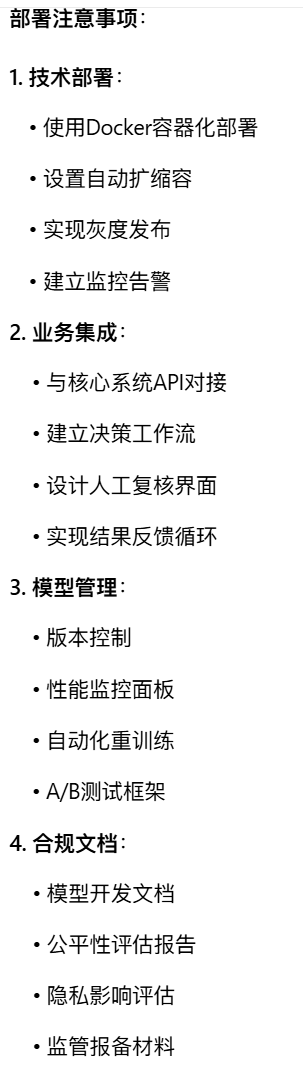

自己遇见的问题和解决方案：

1、在3.2 特征衍生与构造，groupby分组之后agg，需要用reset_index(),否则无法使用age_group_analysis['AGE_GROUP'].它找不到AGE_GROUP的列名。

2、多次运行4.2特征相关性模块时报错'AGE_GROUP'找不到。原因是第一次运行就删除了AGF_GROUP，所以后面几次运行就找不到此列报错。解决方案：copy()后drop代码放在上一模块，避免多次运行找不到此列。